In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-chronic/Chronic_Data_Clean.csv


In [2]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import lightgbm as lgb

In [3]:
file_path = '/kaggle/input/new-chronic/Chronic_Data_Clean.csv'
df = pd.read_csv(file_path)
demographic_features = df[['Gender', 'Age', 'Post onset']]
scan_feature_start = df.columns.get_loc('CinMid - GM')
scan_features = df.iloc[:, scan_feature_start:]

In [4]:
#----------------------------Feature Selection---------------------------------#
selected_features = list(demographic_features) + list(scan_features)
categorical_features = ['Gender']
numerical_features = ['Age', 'Post onset'] + list(scan_features)

#------------------------------------------------------------------------------#
X = df[selected_features].copy()
y = df['Aphasia_severity'].copy()

#------------------------------Number of Trials--------------------------------#
n_trials = 500

#-------------------------------Random Seed------------------------------------#
seed = 42
np.random.seed(seed)
random.seed(seed)

#-------------------------------CV Strategy------------------------------------#
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)



In [5]:
combinations = [
    # 6 classes
    [[0], [1], [2], [3], [4], [5]],

    # 5 classes
    [[0, 1], [2], [3], [4], [5]],
    [[0], [1, 2], [3], [4], [5]],
    [[0], [1], [2, 3], [4], [5]],
    [[0], [1], [2], [3, 4], [5]],
    [[0], [1], [2], [3], [4, 5]],

    # 4 classes
    [[0], [1], [2, 3, 4], [5]],
    [[0], [1], [2, 3], [4, 5]],
    [[0], [1], [2], [3, 4, 5]],
    [[0], [1, 2], [3, 4], [5]],
    [[0], [1, 2], [3], [4, 5]],
    [[0], [1, 2, 3], [4], [5]],
    [[0, 1], [2], [3], [4, 5]],
    [[0, 1], [2], [3, 4], [5]],
    [[0, 1], [2, 3], [4], [5]],
    [[0, 1, 2], [3], [4], [5]],

    # # 3 classes
    [[0], [1, 2, 3, 4], [5]],
    [[0], [1, 2, 3], [4, 5]],
    [[0], [1, 2], [3, 4, 5]],
    [[0], [1], [2, 3, 4, 5]],
    [[0, 1], [2, 3, 4], [5]],
    [[0, 1], [2, 3], [4, 5]],
    [[0, 1], [2], [3, 4, 5]],
    [[0, 1, 2], [3, 4], [5]],
    [[0, 1, 2], [3], [4, 5]],
    [[0, 1, 2, 3], [4], [5]]
]

In [6]:
def remap_labels(y, combos):
    remapped_y = y.copy()
    for i, combo in enumerate(combos):
        for label in combo:
            remapped_y[y == label] = i
    return remapped_y

# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# smt = SMOTE(random_state=seed)
# def create_pipeline(model, numerical_features, categorical_features):
#     numerical_pipeline = Pipeline([
#         ('scaler', StandardScaler())
#     ])
#     categorical_pipeline = Pipeline([
#         ('encoder', OneHotEncoder())
#     ])
#     preprocessor = ColumnTransformer([
#         ('numerical', numerical_pipeline, numerical_features),
#         ('categorical', categorical_pipeline, categorical_features)
#     ])
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('smote', smt),
#         ('model', model)
#     ])
#     return pipeline

# from sklearn.pipeline import Pipeline
# def create_pipeline(model, numerical_features, categorical_features):
#     numerical_pipeline = Pipeline([
#         ('scaler', StandardScaler())
#     ])
#     categorical_pipeline = Pipeline([
#         ('encoder', OneHotEncoder())
#     ])
#     preprocessor = ColumnTransformer([
#         ('numerical', numerical_pipeline, numerical_features),
#         ('categorical', categorical_pipeline, categorical_features)
#     ])
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('model', model)
#     ])
#     return pipeline

def optimize_model_parameters(combinations, X, y, remap_labels, objective, cv, n_trials, seed=42):
    dfs = {}
    drop_id = ['datetime_start', 'datetime_complete', 'duration', 'state']
    best_params_dict = {}

    for idx, combination in enumerate(combinations):
        y_remapped = remap_labels(y, combination)
        study_name = f"Combo_{idx}"
        study = optuna.create_study(direction='maximize', study_name=study_name)
        study.optimize(lambda trial: objective(trial, X, y_remapped, cv=cv, random_state=seed), n_trials=n_trials)
        dfs[study_name] = study.trials_dataframe().drop(drop_id, axis=1)

        best_params_dict[study_name] = study.best_params
        print(f'\nBest params of {study_name}\n {best_params_dict[study_name]}\n')
    return best_params_dict, dfs

def compute_scores(pipeline, X, y_remapped, cv, scoring_metrics):
    scores = cross_validate(pipeline, X, y_remapped, cv=cv, scoring=scoring_metrics)
    mean_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring_metrics.keys()}
    std_scores = {metric: np.std(scores[f'test_{metric}']) for metric in scoring_metrics.keys()}
    formatted_scores = {metric: f"{mean_scores[metric]:.3f} ± {std_scores[metric]:.3f}" for metric in scoring_metrics.keys()}
    return formatted_scores

def process_results(pipeline, X, y_remapped, cv, scoring_metrics, idx, combination, params, all_results):
    formatted_scores = compute_scores(pipeline, X, y_remapped, cv, scoring_metrics)
    all_results.append({
        'idx': idx,
        'combination': combination,
        **formatted_scores,
        'best_params': params,
    })    

def plot_cv_results(all_results):
    modified_results = pd.DataFrame()
    if callable(scoring):
        scoring_name = 'weighted_balanced_accuracy'
    else:
        scoring_name = scoring
    modified_results['idx'] = all_results['idx']
    modified_results[f'mean_{scoring_name}'] = all_results[scoring_name].apply(lambda x: float(x.split(' ± ')[0]))
    modified_results[f'std_{scoring_name}'] = all_results[scoring_name].apply(lambda x: float(x.split(' ± ')[1]))

    sns.barplot(data=modified_results, x='idx', y=f'mean_{scoring_name}',  errorbar='sd')
    plt.errorbar(modified_results['idx'], modified_results[f'mean_{scoring_name}'], yerr=modified_results[f'std_{scoring_name}'], fmt='none', color='black')
    plt.title(f'CV Score for {scoring_name}')
    plt.xlabel('Index')
    plt.ylabel('Mean Score')
    plt.show()

def analyze_results(pipeline, X, y_remapped, cv, idx, combination, misclassified_cases, plot=False, type='mean', error_case=False):
    if plot:    
        sum_conf_matrix = np.zeros((len(combination), len(combination)))
        conf_matrices = []

        for train_index, test_index in cv.split(X, y_remapped):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y_remapped[train_index], y_remapped[test_index]
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            
            if type=='median':
                conf_matrix = confusion_matrix(y_test, y_pred)
                print(conf_matrix)
                conf_matrices.append(conf_matrix)
            if type=='mean':
                conf_matrix = confusion_matrix(y_test, y_pred)
                print(conf_matrix)
                sum_conf_matrix += conf_matrix

            if error_case:
                misclassified_indices = np.where(y_pred != y_test)[0]
                misclassified_samples_indices = test_index[misclassified_indices]
                misclassified_labels = y_test.iloc[misclassified_indices].values    
                misclassified_predictions = y_pred[misclassified_indices]
                misclassified_cases.append({
                    'idx': idx,
                    'combination': combination,
                    'misclassified_samples': misclassified_samples_indices,
                    'number_wrong_cases':len(misclassified_samples_indices),
                    'true_labels': misclassified_labels,
                    'predicted_labels': misclassified_predictions
                })
            
        if type=='mean':
            avg_conf_matrix = sum_conf_matrix / 5
            plt.figure(figsize=(8, 6),dpi=300)
            sns.heatmap(avg_conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
            plt.title(f"{idx}-{combination}-Average Confusion Matrix")
            plt.xlabel("Predicted labels")
            plt.ylabel("True labels")
            plt.show()

        if type=='median':
            median_conf_matrix = np.median(conf_matrices, axis=0)
            plt.figure(figsize=(8, 6),dpi=300)
            sns.heatmap(median_conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
            plt.title(f"{idx}-{combination}-Median Confusion Matrix")
            plt.xlabel("Predicted labels")
            plt.ylabel("True labels")
            plt.show()     


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
def plot_roc_auc(pipeline, X, y_remapped, cv, idx, combination):
    micro_roc_auc_scores = []
    macro_roc_auc_scores = []
    fold=1
    for train_index, test_index in cv.split(X, y_remapped):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_remapped[train_index], y_remapped[test_index]
        pipeline.fit(X_train, y_train)
        y_score = pipeline.predict_proba(X_test)
        num_classes = len(combination)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            y_test_bin = label_binarize(y_test, classes=[i])
            fpr[i], tpr[i], _ = roc_curve(y_test_bin, y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
        fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        micro_roc_auc_scores.append(roc_auc_micro)

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(num_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= num_classes
        fpr_macro = all_fpr
        tpr_macro = mean_tpr
        roc_auc_macro = auc(fpr_macro, tpr_macro)
        macro_roc_auc_scores.append(roc_auc_macro)

        plt.figure(figsize=(10, 6),dpi=300)

        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

        plt.plot(fpr_micro, tpr_micro,
                label='Micro-average ROC curve (area = {0:0.2f})'
                      ''.format(roc_auc_micro),
                color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr_macro, tpr_macro,
                label='Macro-average ROC curve (area = {0:0.2f})'
                      ''.format(roc_auc_macro),
                color='navy', linestyle=':', linewidth=4)

        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC AUC Curve for Multiclass Classification - Fold {fold}')
        plt.legend(loc="lower right")
        plt.show()
        fold+=1

    avg_micro_roc_auc = np.mean(micro_roc_auc_scores)
    avg_macro_roc_auc = np.mean(macro_roc_auc_scores)

    plt.figure(figsize=(10, 6),dpi=300)
    plt.plot(range(len(micro_roc_auc_scores)), micro_roc_auc_scores, label='Micro-average ROC AUC')
    plt.plot(range(len(macro_roc_auc_scores)), macro_roc_auc_scores, label='Macro-average ROC AUC')
    plt.axhline(y=avg_micro_roc_auc, color='r', linestyle='--', label='Average Micro-average ROC AUC')
    plt.axhline(y=avg_macro_roc_auc, color='g', linestyle='--', label='Average Macro-average ROC AUC')
    plt.xlabel('Fold')
    plt.ylabel('ROC AUC Score')
    plt.title('Micro-average and Macro-average ROC AUC Scores Across Folds')
    plt.legend()
    plt.show()            

In [63]:
combinations_ = [combinations[17]]
combinations_

[[[0], [1, 2, 3], [4, 5]]]

In [64]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=seed)
def create_pipeline(model, numerical_features, categorical_features):
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('encoder', OneHotEncoder())
    ])
    preprocessor = ColumnTransformer([
        ('numerical', numerical_pipeline, numerical_features),
        ('categorical', categorical_pipeline, categorical_features)
    ])
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', smt),
        ('model', model)
    ])
    return pipeline

In [23]:
from sklearn.model_selection import train_test_split

In [65]:
for idx, combination in enumerate(combinations_):
    y_remapped = remap_labels(y, combination)
    params = {'booster': 'gbtree', 'lambda': 0.0006504111243096067, 'alpha': 0.0022093221198215187, 'max_depth': 10, 'learning_rate': 0.49029935492233095, 'n_estimators': 403, 'subsample': 0.4272968090040694, 'colsample_bytree': 0.7899715391834701, 'min_child_weight': 6, 'gamma': 0.4068228506620585}
    #-------------------------------------------------------------------------#
    model = xgb.XGBClassifier(**params,
                              objective="multi:softmax",
                              eval_metric="mlogloss",
                              use_label_encoder=False ,
                              random_state=seed,
                              tree_method = "hist",
                              verbosity=1)
    #-------------------------------------------------------------------------#

    pipeline = create_pipeline(model, numerical_features, categorical_features)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Post onset',
                                                   'CinMid - GM',
                                                   'PariInf - GM',
                                                   'FrSupMed - GM',
                                                   'TempPSup - GM',
                                                   'Angular - GM',
                                                   'TempSup - GM',
                                                   'Calcarine - GM',
                                                   'Amygdala - GM',
                                                   'RolOper - GM',
                                                   'Insula - GM', 'Heschl - GM',
                                                   'FrInfTri - GM',
                                                   'FrInfOrb - GM',
                                                   'OccInf - GM', 'OccMid - GM',
                                                   'FrMid - GM',...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               lambda=0.0006504111243096067,
                               learning_rate=0.49029935492233095, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=6, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=403, n_jobs=None, ...))])

In [52]:
def weighted_balanced_accuracy(y_true, y_pred):
    # Unique classes in the true labels
    classes = np.unique(y_true)
    # Compute class weights based on the frequency of each class
    class_weights = compute_class_weight('balanced', classes=classes, y=y_true)
    # Mapping class weights to target classes
    class_weight_dict = dict(zip(classes, class_weights))
    # Compute recall for each class
    recalls = recall_score(y_true, y_pred, labels=classes, average=None)
    # Weighted sum of recalls
    weighted_recalls = recalls * np.array([class_weight_dict[cls] for cls in classes])
    # Sum of weights
    sum_of_weights = np.sum(class_weights)
    # Weighted Balanced Accuracy
    weighted_balanced_accuracy = np.sum(weighted_recalls) / sum_of_weights
    return weighted_balanced_accuracy

weighted_ba_scorer = make_scorer(weighted_balanced_accuracy)

scoring = 'accuracy'

from sklearn.metrics import fbeta_score, make_scorer

def fbeta_macro(y_true, y_pred, beta=1):
    return fbeta_score(y_true, y_pred, beta=beta, average='macro')

scoring_metrics = {
  'accuracy': 'accuracy',
  'balanced_accuracy': 'balanced_accuracy',
  'weighted_balanced_accuracy': weighted_ba_scorer,
  'precision_macro': 'precision_macro',
  'recall_macro': 'recall_macro',
  'f1_macro': 'f1_macro',
  'f0.5_macro': make_scorer(fbeta_macro, beta=0.5),
  'f2_macro': make_scorer(fbeta_macro, beta=2),
}

In [66]:
all_results = []
process_results(pipeline, X, y_remapped, cv, scoring_metrics, idx, combination, params, all_results)
all_results

[{'idx': 0,
  'combination': [[0], [1, 2, 3], [4, 5]],
  'accuracy': '0.729 ± 0.034',
  'balanced_accuracy': '0.677 ± 0.085',
  'weighted_balanced_accuracy': '0.620 ± 0.150',
  'precision_macro': '0.694 ± 0.041',
  'recall_macro': '0.677 ± 0.085',
  'f1_macro': '0.673 ± 0.060',
  'f0.5_macro': '0.681 ± 0.046',
  'f2_macro': '0.673 ± 0.074',
  'best_params': {'booster': 'gbtree',
   'lambda': 0.0006504111243096067,
   'alpha': 0.0022093221198215187,
   'max_depth': 10,
   'learning_rate': 0.49029935492233095,
   'n_estimators': 403,
   'subsample': 0.4272968090040694,
   'colsample_bytree': 0.7899715391834701,
   'min_child_weight': 6,
   'gamma': 0.4068228506620585}}]

In [55]:
all_results = []
process_results(pipeline, X, y_remapped, cv, scoring_metrics, idx, combination, params, all_results)
all_results

[{'idx': 125,
  'combination': [[0], [1, 2, 3], [4, 5]],
  'accuracy': '0.776 ± 0.047',
  'balanced_accuracy': '0.711 ± 0.047',
  'weighted_balanced_accuracy': '0.628 ± 0.070',
  'precision_macro': '0.771 ± 0.080',
  'recall_macro': '0.711 ± 0.047',
  'f1_macro': '0.726 ± 0.054',
  'f0.5_macro': '0.747 ± 0.065',
  'f2_macro': '0.714 ± 0.048',
  'best_params': {'booster': 'gbtree',
   'lambda': 0.0006504111243096067,
   'alpha': 0.0022093221198215187,
   'max_depth': 10,
   'learning_rate': 0.49029935492233095,
   'n_estimators': 403,
   'subsample': 0.4272968090040694,
   'colsample_bytree': 0.7899715391834701,
   'min_child_weight': 6,
   'gamma': 0.4068228506620585}}]

In [54]:
# 创建包含表格数据的 DataFrame
data = {
    "ID": [2, 8, 9, 265, 270, 149, 165, 169, 184, 189, 317, 191, 202, 76, 78, 207, 213, 86, 87, 215, 102, 236, 110, 125],
    "predicted_label": [1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0]
}

labels = pd.DataFrame(data)

# 方法 1：随机选择数字改变 y
for idx in labels['ID']:
    y_remapped.iloc[idx] = np.random.choice([0, 1, 2])

# 打印随机修改后的 y
print("随机修改后的 y：")
print(y_remapped[labels['ID']])

# 方法 2：根据 predicted_label 改变 y
for idx, predicted_label in zip(labels['ID'], labels['predicted_label']):
    y_remapped.iloc[idx] = predicted_label

# 打印根据 predicted_label 修改后的 y
print("根据 predicted_label 修改后的 y：")
print(y_remapped[labels['ID']])

根据 predicted_label 修改后的 y：
2      1
8      1
9      1
265    0
270    0
149    2
165    1
169    1
184    1
189    1
317    0
191    1
202    1
76     2
78     0
207    1
213    1
86     1
87     0
215    2
102    2
236    2
110    1
125    0
Name: Aphasia_severity, dtype: int64


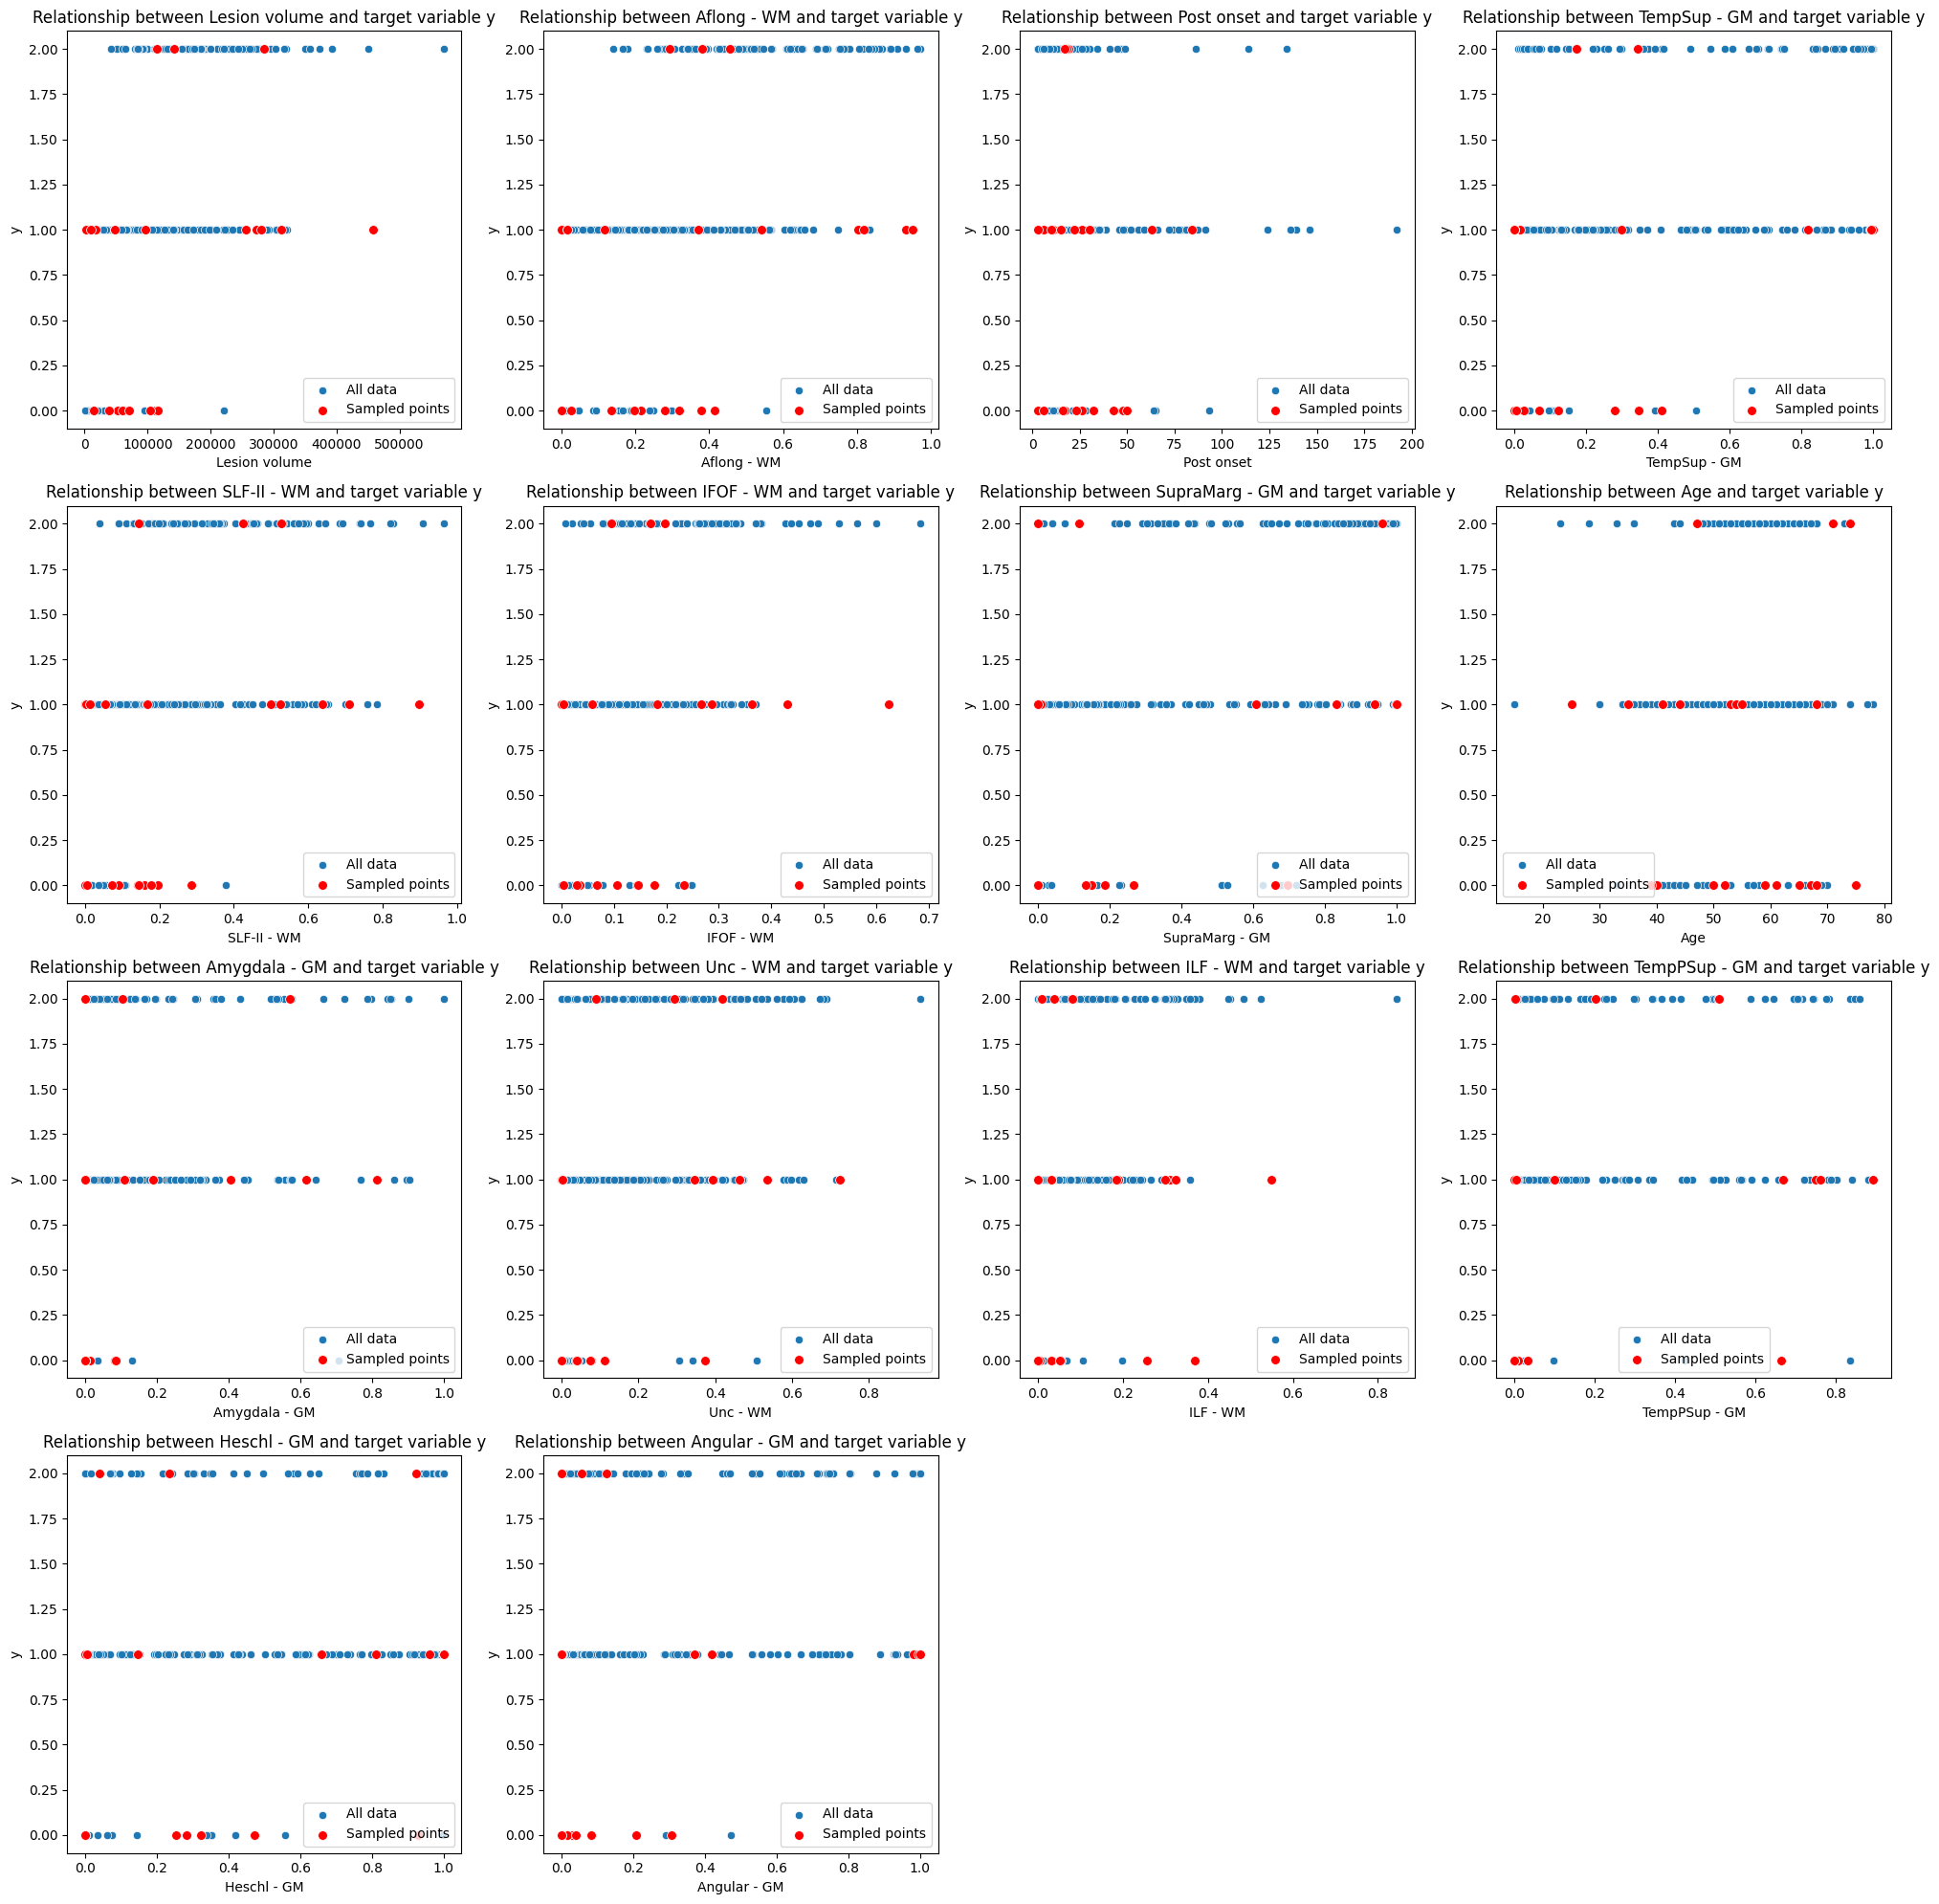

In [35]:
# Create a 4x4 subplot layout
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration

# Plot each column in the subplot
for i, column in enumerate(columns_of_interest):
    ax = axes[i]
    sns.scatterplot(data=X, x=column, y=y_remapped, ax=ax, label='All data')
    sns.scatterplot(x=sampled_X[column], y=sampled_y, color='red', s=50, ax=ax, label='Sampled points', zorder=5)
    ax.set_title(f'Relationship between {column} and target variable y')
    ax.set_xlabel(column)
    ax.set_ylabel('y')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

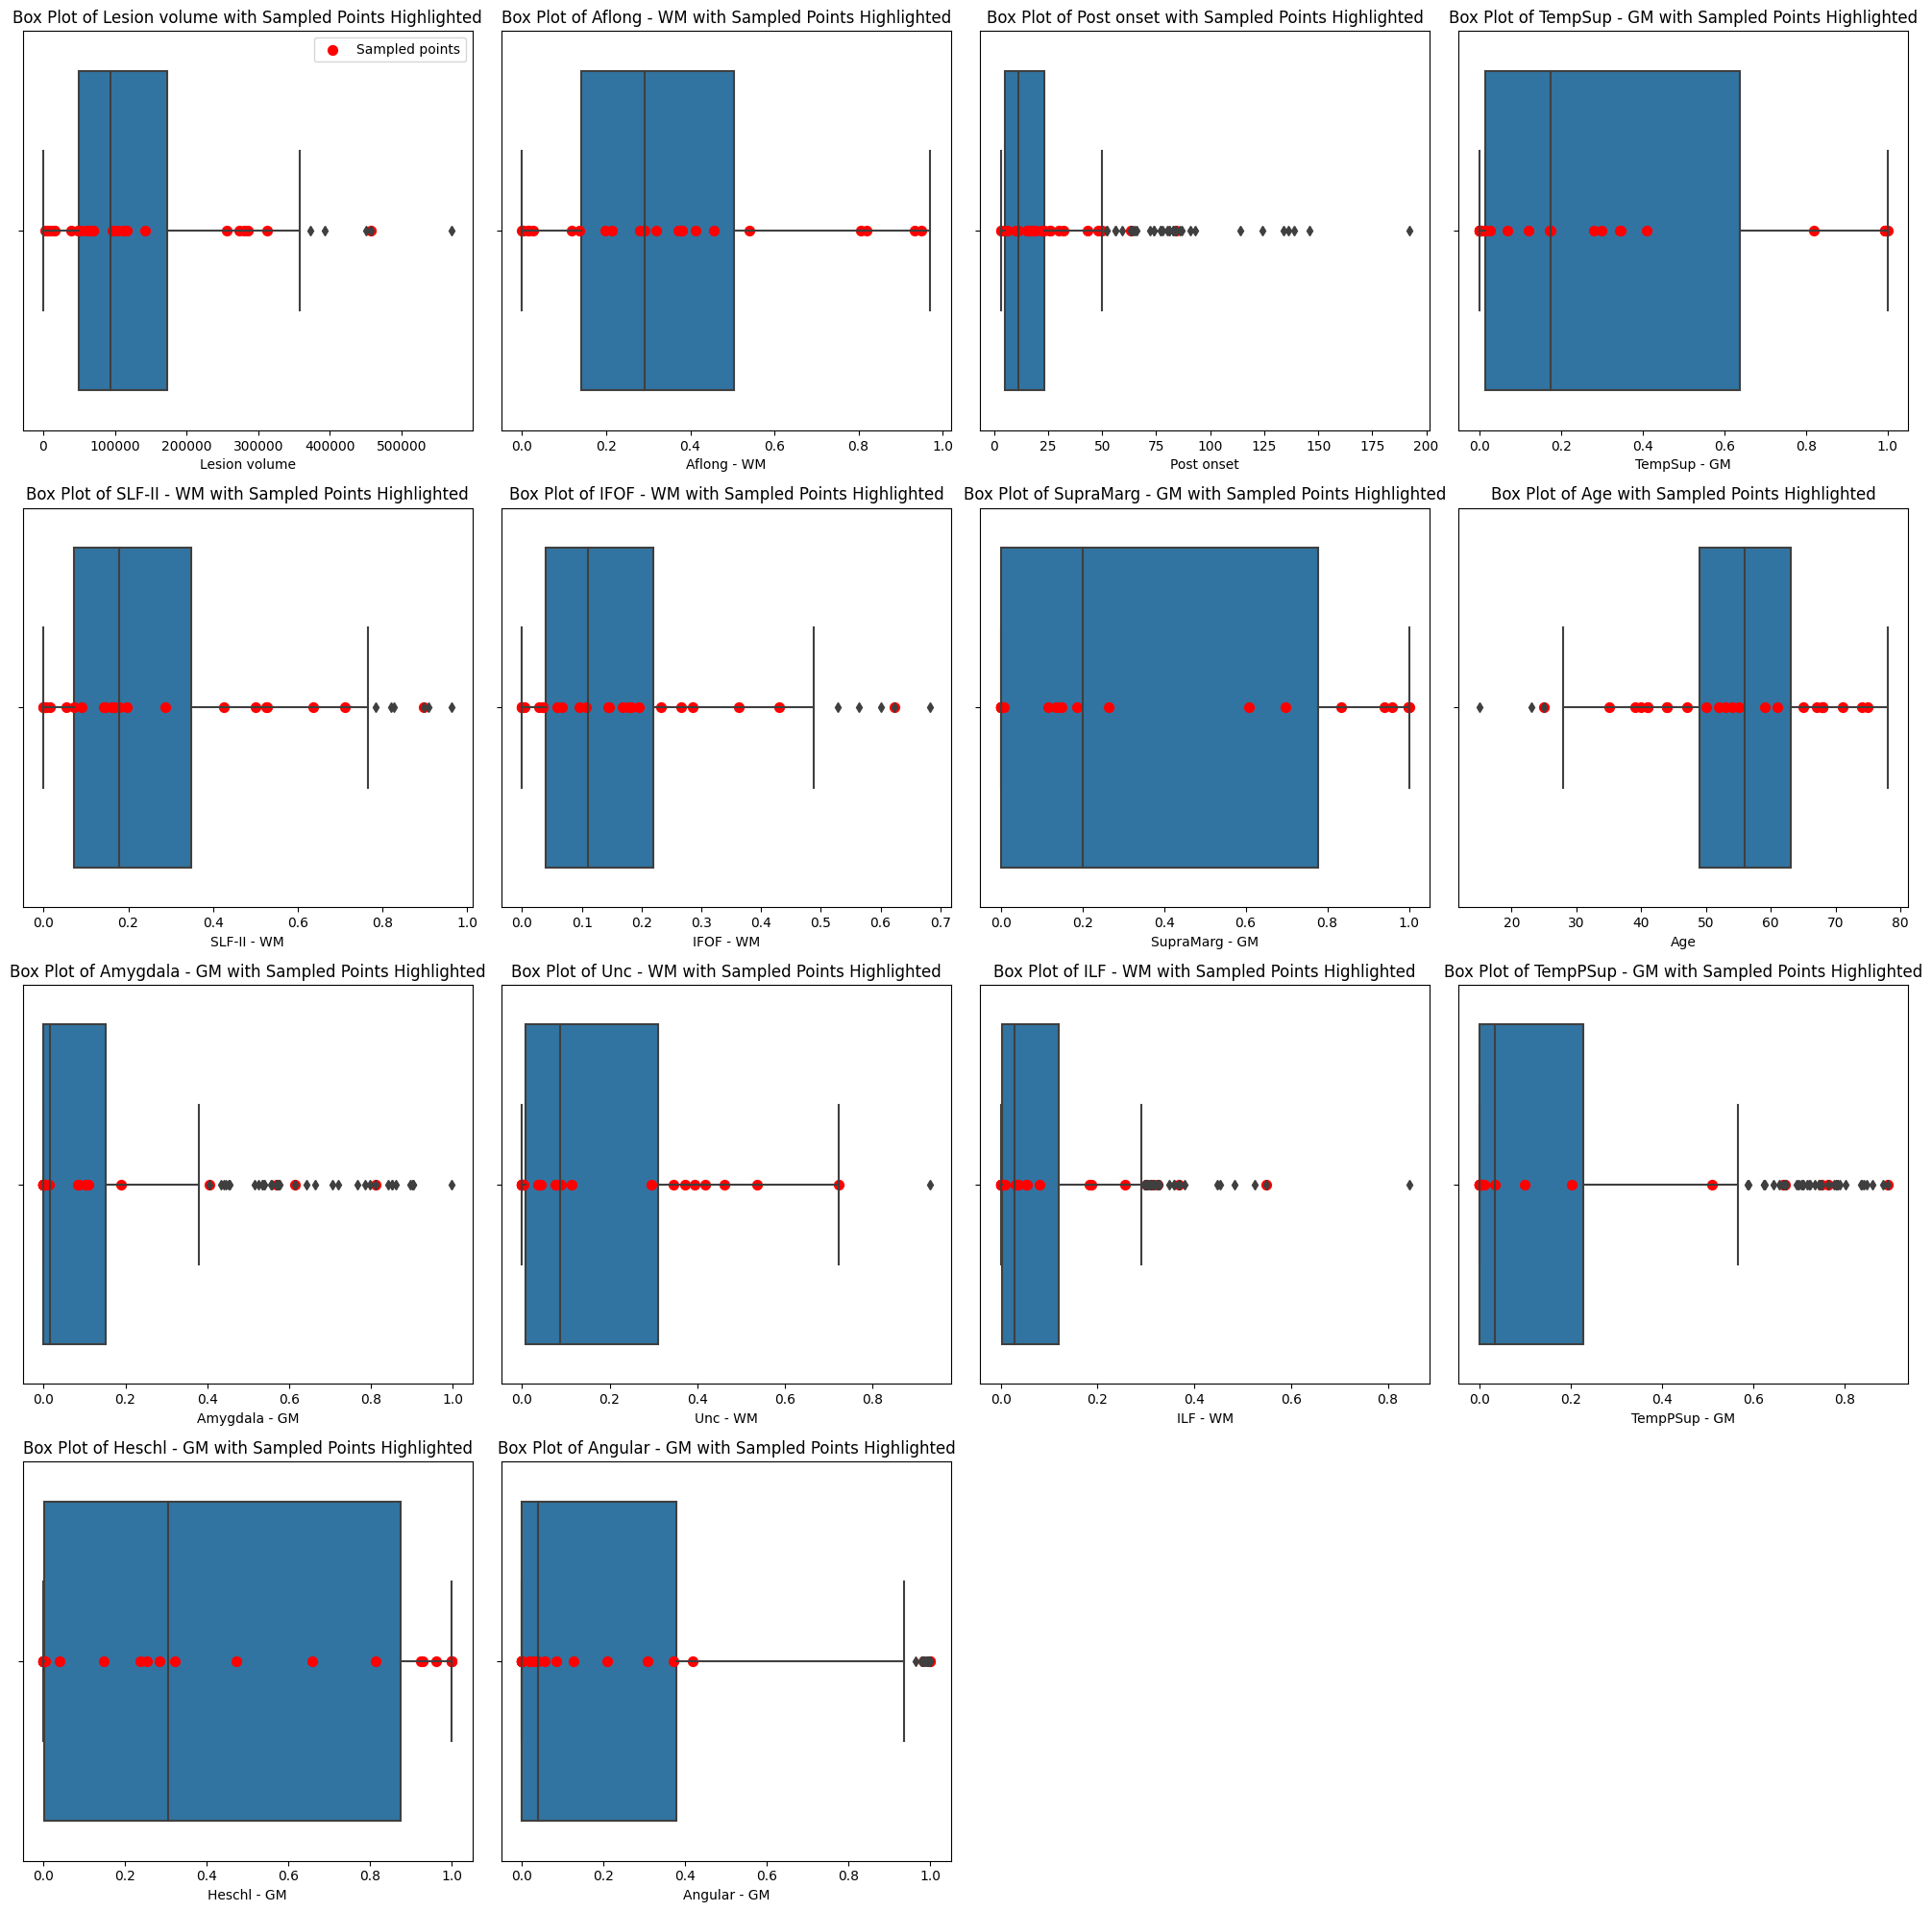

In [37]:
# Create a 4x4 subplot layout
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration

# Plot each column in the subplot
for i, column in enumerate(columns_of_interest):
    ax = axes[i]
    sns.boxplot(x=X[column], ax=ax)
    ax.scatter(sampled_X[column], [0]*len(sampled_X), color='red', s=50, label='Sampled points')
    ax.set_title(f'Box Plot of {column} with Sampled Points Highlighted')
    ax.set_xlabel(column)
    if i == 0:
        ax.legend()  # Only add legend to the first subplot for clarity

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [26]:
n_classes =3 
X_train, X_rest, y_train, y_rest = train_test_split(X, y_remapped, test_size=0.4, stratify=y_remapped, random_state=42)
X_Cal, X_test, y_cal, y_test = train_test_split(X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:0.3f}")
for i in range(n_classes):
    recall = np.mean(y_pred[y_test == i] == y_test[y_test == i])
    print(f"Recall for class {[i]}: {recall:0.3f}")

Accuracy: 0.692
Recall for class [0]: 0.625
Recall for class [1]: 0.667
Recall for class [2]: 0.778


In [27]:
# Get class counts
def get_class_counts(y_test):
    class_counts = []
    for i in range(n_classes):
        class_counts.append(np.sum(y_test == i))
    return class_counts

# Get coverage for each class
def get_coverage_by_class(prediction_sets, y_test):
    coverage = []
    for i in range(n_classes):
        coverage.append(np.mean(prediction_sets[y_test == i, i]))
    return coverage

# Get average set size for each class
def get_average_set_size(prediction_sets, y_test):
    average_set_size = []
    for i in range(n_classes):
        average_set_size.append(
            np.mean(np.sum(prediction_sets[y_test == i], axis=1)))
    return average_set_size     

# Get weighted coverage (weighted by class size)
def get_weighted_coverage(coverage, class_counts):
    total_counts = np.sum(class_counts)
    weighted_coverage = np.sum((coverage * class_counts) / total_counts)
    weighted_coverage = round(weighted_coverage, 3)
    return weighted_coverage

# Get weighted set_size (weighted by class size)
def get_weighted_set_size(set_size, class_counts):
    total_counts = np.sum(class_counts)
    weighted_set_size = np.sum((set_size * class_counts) / total_counts)
    weighted_set_size = round(weighted_set_size, 3)
    return weighted_set_size

# Get predictions for calibration set
y_pred = pipeline.predict(X_Cal)
y_pred_proba = pipeline.predict_proba(X_Cal)
si_scores = []
# Loop through all calibration instances
for i, true_class in enumerate(y_cal):
    # Get predicted probability for observed/true class
    predicted_prob = y_pred_proba[i][true_class]
    si_scores.append(1 - predicted_prob)    

# Convert to NumPy array
si_scores = np.array(si_scores)
number_of_samples = len(X_Cal)
alpha = 0.05
qlevel = (1 - alpha) * ((number_of_samples + 1) / number_of_samples)
threshold = np.percentile(si_scores, qlevel*100)
print(f'Threshold: {threshold:0.3f}')
prediction_sets = (1 - pipeline.predict_proba(X_test) <= threshold)
class_labels = ['0','1','2']
# Get standard predictions
y_pred = pipeline.predict(X_test)

# Function to get set labels
def get_prediction_set_labels(prediction_set, class_labels):
    # Get set of class labels for each instance in prediction sets
    prediction_set_labels = [
        set([class_labels[i] for i, x in enumerate(prediction_set) if x]) for prediction_set in 
        prediction_sets]
    return prediction_set_labels

# Collate predictions
results_sets = pd.DataFrame()
results_sets['observed'] = [class_labels[i] for i in y_test]
results_sets['labels'] = get_prediction_set_labels(prediction_sets, class_labels)
results_sets['classifications'] = [class_labels[i] for i in y_pred]

results = pd.DataFrame(index=class_labels)
results['Class counts'] = get_class_counts(y_test)
results['Coverage'] = get_coverage_by_class(prediction_sets, y_test)
results['Average set size'] = get_average_set_size(prediction_sets, y_test)
print(results)

weighted_coverage = get_weighted_coverage(
    results['Coverage'], results['Class counts'])

weighted_set_size = get_weighted_set_size(
    results['Average set size'], results['Class counts'])

print (f'Overall coverage: {weighted_coverage}')
print (f'Average set size: {weighted_set_size}')

Threshold: 0.987
   Class counts  Coverage  Average set size
0             8       1.0          2.250000
1            39       1.0          2.153846
2            18       1.0          2.111111
Overall coverage: 1.0
Average set size: 2.154


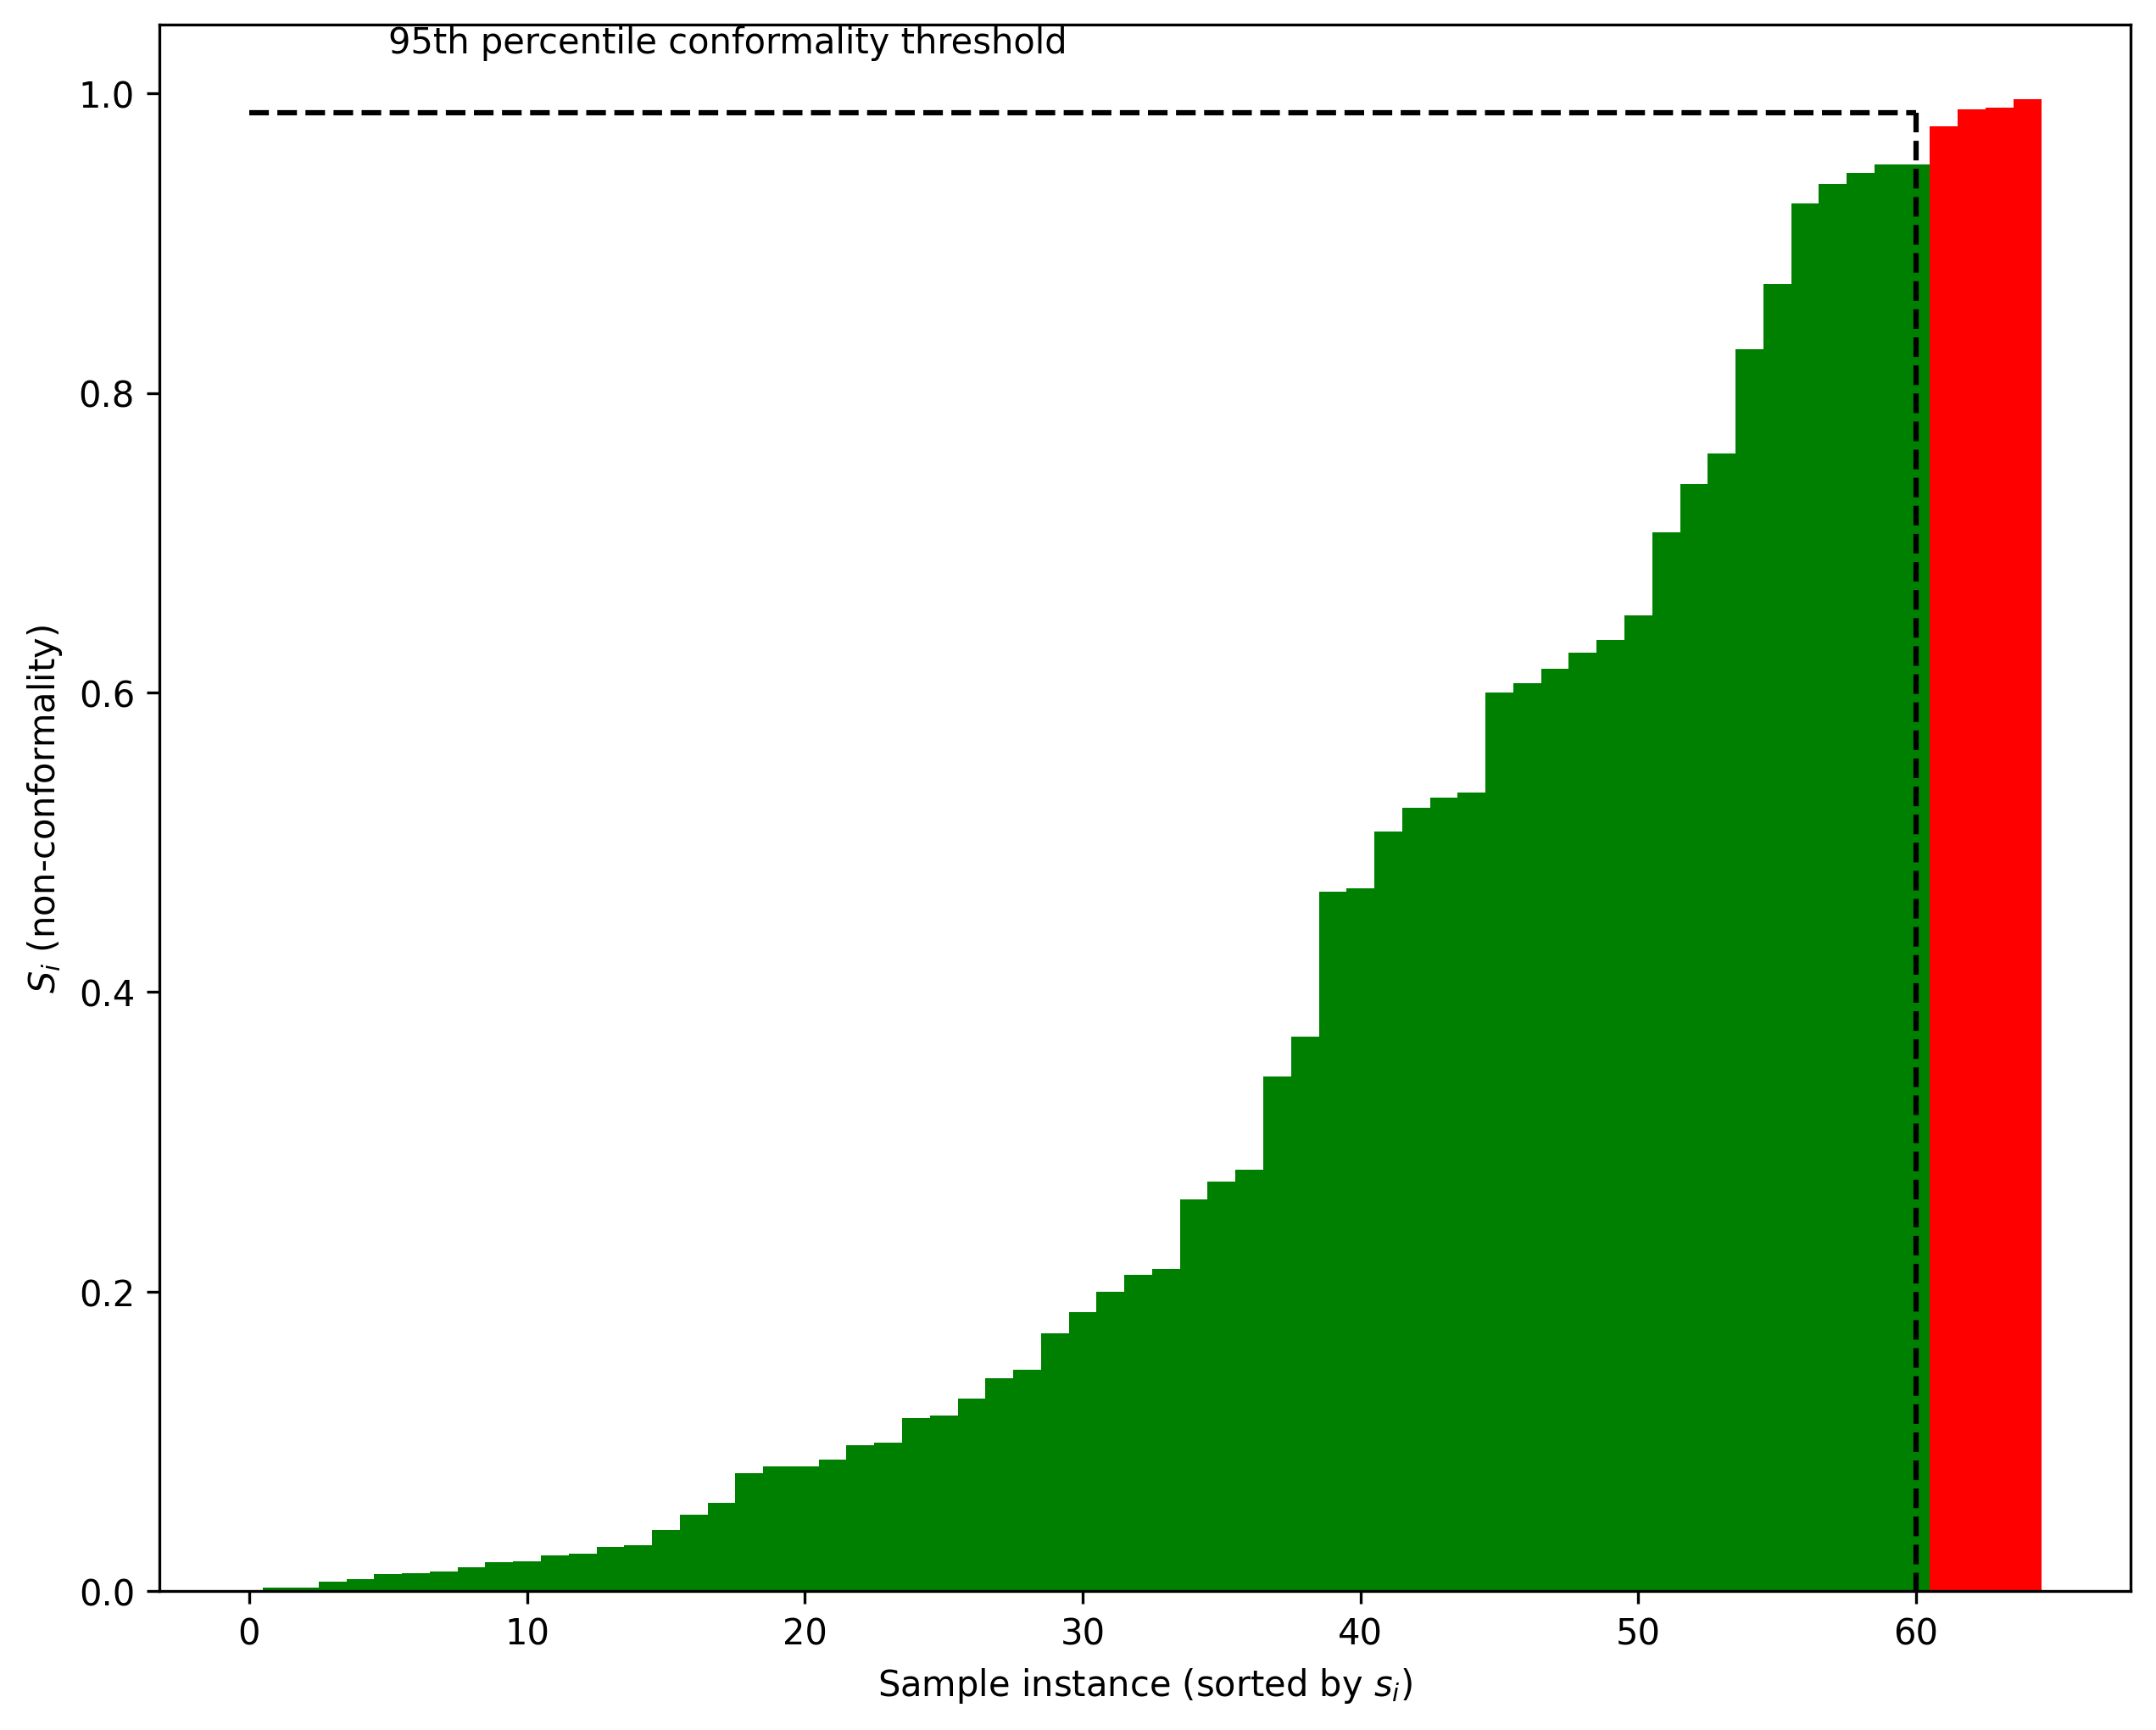

In [28]:
x = np.arange(len(si_scores)) + 1
sorted_si_scores = np.sort(si_scores)
index_of_95th_percentile = int(len(si_scores) * 0.95)

# Color by cut-off
conform = 'g' * index_of_95th_percentile
nonconform = 'r' * (len(si_scores) - index_of_95th_percentile)
color = list(conform + nonconform)

fig = plt.figure(figsize=((10,8)),dpi=300)
ax = fig.add_subplot()

# Add bars
ax.bar(x, sorted_si_scores, width=1.0, color = color)

# Add lines for 95th percentile
ax.plot([0, index_of_95th_percentile],[threshold, threshold], 
        c='k', linestyle='--')
ax.plot([index_of_95th_percentile, index_of_95th_percentile], [threshold, 0],
        c='k', linestyle='--')

# Add text
txt = '95th percentile conformality threshold'
ax.text(5, threshold + 0.04, txt)

# Add axis labels
ax.set_xlabel('Sample instance (sorted by $s_i$)')
ax.set_ylabel('$S_i$ (non-conformality)')

plt.show()

In [29]:
# Set alpha (1 - coverage)
alpha = 0.05
thresholds = []
# Get predicted probabilities for calibration set
y_cal_prob = pipeline.predict_proba(X_Cal)
# Get 95th percentile score for each class's s-scores
for class_label in range(n_classes):
    mask = y_cal == class_label
    y_cal_prob_class = y_cal_prob[mask][:, class_label]
    s_scores = 1 - y_cal_prob_class
    q = (1 - alpha) * 100
    class_size = mask.sum()
    print(class_size)
    if class_size > 10:
        correction = (class_size + 1) / class_size
    else:
        correction = (class_size + 0.1) / class_size
    q *= correction
    print(q)
    if q > 100:
        correction = (class_size + 0.1) / class_size
        q = (1 - alpha) * 100
        q *= correction
        print(q)
        
    threshold = np.percentile(s_scores, q)
    thresholds.append(threshold)

print(thresholds)

8
96.1875
39
97.43589743589743
17
100.58823529411765
95.55882352941177
[0.994238201752305, 0.9270460223540281, 0.9815913260684294]


In [30]:
# Get Si scores for test set
predicted_proba = pipeline.predict_proba(X_test)
si_scores = 1 - predicted_proba

# For each class, check whether each instance is below the threshold
prediction_sets = []
for i in range(n_classes):
    prediction_sets.append(si_scores[:, i] <= thresholds[i])
prediction_sets = np.array(prediction_sets).T

# Get prediction set labels and show first 10
prediction_set_labels = get_prediction_set_labels(prediction_sets, class_labels)

# Get standard predictions
y_pred = pipeline.predict(X_test)

# Collate predictions
results_sets = pd.DataFrame()
results_sets['observed'] = [class_labels[i] for i in y_test]
results_sets['labels'] = get_prediction_set_labels(prediction_sets, class_labels)
results_sets['classifications'] = [class_labels[i] for i in y_pred]

# Show first 10 results
results_sets.head(10)

,observed,labels,classifications
0,1,{0},0
1,0,"{2, 1, 0}",0
2,1,"{2, 1, 0}",1
3,2,"{2, 1, 0}",1
4,1,{0},0
5,0,"{1, 0}",0
6,1,{1},1
7,1,"{1, 0}",0
8,1,"{1, 0}",1
9,1,"{1, 0}",1


In [31]:
results = pd.DataFrame(index=class_labels)
results['Class counts'] = get_class_counts(y_test)
results['Coverage'] = get_coverage_by_class(prediction_sets, y_test)
results['Average set size'] = get_average_set_size(prediction_sets, y_test)
results

,Class counts,Coverage,Average set size
0,8,1.000000,2.125000
1,39,0.923077,2.153846
2,18,1.000000,2.055556


In [32]:
weighted_coverage = get_weighted_coverage(
    results['Coverage'], results['Class counts'])

weighted_set_size = get_weighted_set_size(
    results['Average set size'], results['Class counts'])

print (f'Overall coverage: {weighted_coverage}')
print (f'Average set size: {weighted_set_size}')

Overall coverage: 0.954
Average set size: 2.123


In [46]:
skf = cv
weighted_coverages = 0
weighted_coverages2 = 0
weighted_set_sizes = 0
for train_index, test_index in skf.split(X, y_remapped):
    X_train, X_rest = X.iloc[train_index], X.iloc[test_index]
    y_train, y_rest = y_remapped[train_index], y_remapped[test_index]
    n_classes = 3
    X_Cal, X_test, y_cal, y_test = train_test_split(X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=42)
    params = {'booster': 'gbtree', 'lambda': 0.0006504111243096067, 'alpha': 0.0022093221198215187, 'max_depth': 10, 'learning_rate': 0.49029935492233095, 'n_estimators': 403, 'subsample': 0.4272968090040694, 'colsample_bytree': 0.7899715391834701, 'min_child_weight': 6, 'gamma': 0.4068228506620585}
    #-------------------------------------------------------------------------#
    model = xgb.XGBClassifier(**params,
                              objective="multi:softmax",
                              eval_metric="mlogloss",
                              use_label_encoder=False ,
                              random_state=seed,
                              tree_method = "hist",
                              verbosity=1)
    
#     params = {'class_weight': 'balanced', 'boosting_type': 'gbdt', 'num_leaves': 182, 'max_depth': 14, 'learning_rate': 0.0026540309077107247, 'n_estimators': 1338, 'min_child_samples': 17, 'min_child_weight': 0.6667968973274166, 'subsample': 0.031253963455450486, 'colsample_bytree': 0.7751718608430662, 'reg_alpha': 0.9370902102203016, 'reg_lambda': 0.6319453042669246}

#     #-------------------------------------------------------------------------#
#     model = lgb.LGBMClassifier(**params, objective='multiclass', metric='multi_logloss', verbosity=-1, random_state=seed)
#     #-------------------------------------------------------------------------#

    pipeline = create_pipeline(model, numerical_features, categorical_features)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy:0.3f}")
    for i in range(n_classes):
        recall = np.mean(y_pred[y_test == i] == y_test[y_test == i])
        print(f"Recall for class {[i]}: {recall:0.3f}")


    # Get predictions for calibration set
    y_pred = pipeline.predict(X_Cal)
    y_pred_proba = pipeline.predict_proba(X_Cal)
    si_scores = []
    # Loop through all calibration instances
    for i, true_class in enumerate(y_cal):
        # Get predicted probability for observed/true class
        predicted_prob = y_pred_proba[i][true_class]
        si_scores.append(1 - predicted_prob)    

    # Convert to NumPy array
    si_scores = np.array(si_scores)
    number_of_samples = len(X_Cal)
    alpha = 0.05
    qlevel = (1 - alpha) * ((number_of_samples + 1) / number_of_samples)
    threshold = np.percentile(si_scores, qlevel*100)
    print(f'Threshold: {threshold:0.3f}')
    prediction_sets = (1 - pipeline.predict_proba(X_test) <= threshold)
    class_labels = ['0','1','2']
    # Get standard predictions
    y_pred = pipeline.predict(X_test)
    # Function to get set labels
    def get_prediction_set_labels(prediction_set, class_labels):
        # Get set of class labels for each instance in prediction sets
        prediction_set_labels = [
            set([class_labels[i] for i, x in enumerate(prediction_set) if x]) for prediction_set in 
            prediction_sets]
        return prediction_set_labels

    # Collate predictions
    results_sets = pd.DataFrame()
    results_sets['observed'] = [class_labels[i] for i in y_test]
    results_sets['labels'] = get_prediction_set_labels(prediction_sets, class_labels)
    results_sets['classifications'] = [class_labels[i] for i in y_pred]

    results = pd.DataFrame(index=class_labels)
    results['Class counts'] = get_class_counts(y_test)
    results['Coverage'] = get_coverage_by_class(prediction_sets, y_test)
    results['Average set size'] = get_average_set_size(prediction_sets, y_test)
    print(results)

    weighted_coverage = get_weighted_coverage(
        results['Coverage'], results['Class counts'])

    weighted_set_size = get_weighted_set_size(
        results['Average set size'], results['Class counts'])

    print (f'Overall coverage: {weighted_coverage}')
    print (f'Average set size: {weighted_set_size}')

    weighted_coverages += weighted_coverage
    weighted_set_sizes += weighted_set_size
    # Set alpha (1 - coverage)
    alpha = 0.05
    thresholds = []
    # Get predicted probabilities for calibration set
    y_cal_prob = pipeline.predict_proba(X_Cal)
    # Get 95th percentile score for each class's s-scores
    for class_label in range(n_classes):
        mask = y_cal == class_label
        y_cal_prob_class = y_cal_prob[mask][:, class_label]
        s_scores = 1 - y_cal_prob_class
        q = (1 - alpha) * 100
        class_size = mask.sum()
        print(class_size)
        if class_size > 10:
            correction = (class_size + 1) / class_size
        else:
            correction = (class_size + 0.1) / class_size
        q *= correction
        print('q1',q)
        if q > 100:
            correction = (class_size + 0.1) / class_size
            q = (1 - alpha) * 100
            q *= correction
            print('q2',q)

        threshold = np.percentile(s_scores, q)
        thresholds.append(threshold)

    print(thresholds)
    
    # Get Si scores for test set
    predicted_proba = pipeline.predict_proba(X_test)
    si_scores = 1 - predicted_proba

    # For each class, check whether each instance is below the threshold
    prediction_sets = []
    for i in range(n_classes):
        prediction_sets.append(si_scores[:, i] <= thresholds[i])
    prediction_sets = np.array(prediction_sets).T

    # Get prediction set labels and show first 10
    prediction_set_labels = get_prediction_set_labels(prediction_sets, class_labels)

    # Get standard predictions
    y_pred = pipeline.predict(X_test)

    # Collate predictions
    results_sets = pd.DataFrame()
    results_sets['observed'] = [class_labels[i] for i in y_test]
    results_sets['labels'] = get_prediction_set_labels(prediction_sets, class_labels)
    results_sets['classifications'] = [class_labels[i] for i in y_pred]
    
    results = pd.DataFrame(index=class_labels)
    results['Class counts'] = get_class_counts(y_test)
    results['Coverage'] = get_coverage_by_class(prediction_sets, y_test)
    results['Average set size'] = get_average_set_size(prediction_sets, y_test)
    print(results)
    weighted_coverage = get_weighted_coverage(
    results['Coverage'], results['Class counts'])

    weighted_set_size = get_weighted_set_size(
        results['Average set size'], results['Class counts'])

    print (f'\n\nOverall coverage: {weighted_coverage}')
    print (f'Average set size: {weighted_set_size}')
    
    weighted_coverages2 += weighted_coverage
print(f'\n\n\n Average covergae: {weighted_coverages / 5}')
print(f'\n\n\n Average adjusted covergae: {weighted_coverages2 / 5}')
    

Accuracy: 0.697
Recall for class [0]: 0.250
Recall for class [1]: 0.850
Recall for class [2]: 0.556
Threshold: 1.000
   Class counts  Coverage  Average set size
0             4       1.0          3.000000
1            20       1.0          2.850000
2             9       1.0          2.777778
Overall coverage: 1.0
Average set size: 2.848
4
q1 97.37499999999999
19
q1 100.0
9
q1 96.05555555555556
[0.9964455318450928, 0.8460213541984558, 0.9965361179245843]
   Class counts  Coverage  Average set size
0             4      1.00          2.250000
1            20      0.95          2.350000
2             9      1.00          1.888889


Overall coverage: 0.97
Average set size: 2.212
Accuracy: 0.812
Recall for class [0]: 1.000
Recall for class [1]: 0.800
Recall for class [2]: 0.750
Threshold: 0.951
   Class counts  Coverage  Average set size
0             4     1.000              1.75
1            20     0.950              1.45
2             8     0.875              1.75
Overall coverage: 0.938


In [40]:
weighted_set_sizes/5

1.9402000000000001

In [47]:
weighted_set_sizes/5

2.0631999999999997

In [10]:
pipeline.fit(X,y_remapped)
X_processed = pipeline.named_steps['preprocessor'].transform(X)
categorical_encoder = pipeline.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['encoder']
encoded_categorical_features = categorical_encoder.get_feature_names_out(input_features=categorical_features)
processed_feature_names = numerical_features + list(encoded_categorical_features)
X_processed_df = pd.DataFrame(X_processed, columns=processed_feature_names)
X_processed_df

,Age,Post onset,CinMid - GM,PariInf - GM,FrSupMed - GM,TempPSup - GM,Angular - GM,TempSup - GM,Calcarine - GM,Amygdala - GM,...,SLF-I - WM,FMT - WM,CC - WM,Handinf U - WM,FSL - WM,Fornix - WM,FOP - WM,Lesion volume,Gender_f,Gender_m
0,-0.768819,-0.073673,-0.203207,0.902184,-0.184733,1.403176,-0.662810,-0.523388,-0.159831,1.125391,...,0.764118,-0.376036,0.356913,0.569642,0.985270,1.752746,-0.379820,0.336086,1.0,0.0
1,2.141229,-0.592614,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.237012,...,-0.666467,-0.376036,-1.040717,-0.883254,-0.624203,-0.528063,-0.627330,-1.042607,0.0,1.0
2,-1.425926,0.185798,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.905486,-0.159831,-0.580868,...,-0.679395,-0.376036,-1.104444,-0.883254,-0.634294,-0.473502,-0.628834,-1.113666,0.0,1.0
3,1.390249,-0.221941,-0.242731,-0.635777,-0.184733,-0.510315,-0.030156,-0.767974,-0.159831,-0.330770,...,-0.478163,-0.193987,-0.181533,-0.550093,-0.291508,-0.559278,0.541616,-0.171471,1.0,0.0
4,-1.425926,-0.333143,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.897648,-0.159831,-0.580868,...,-0.679395,-0.376036,-1.000119,-0.883254,-0.634294,-0.582362,-0.655373,-1.041443,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,-0.205584,-0.666748,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.679317,-0.376036,-1.131132,-0.883254,-0.634294,-0.614233,-0.655373,-1.193050,1.0,0.0
317,-0.205584,-0.370210,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.679395,-0.376036,-1.180302,-0.883254,-0.634294,-0.611216,-0.655373,-1.211883,0.0,1.0
318,0.076034,-0.555547,-0.242731,-0.302811,-0.184733,-0.443716,-0.712923,-0.728922,-0.117799,-0.299548,...,-0.302318,-0.376036,0.078066,1.211415,-0.037291,-0.598756,0.214432,0.097300,0.0,1.0
319,0.169906,0.259932,-0.242731,-0.761885,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.522708,-0.376036,-0.922321,-0.780814,-0.525893,-0.615282,-0.569439,-0.898150,1.0,0.0


In [11]:
try:
    import umap
except ModuleNotFoundError:
    !pip install --quiet umap-learn
    import umap


2024-05-18 18:58:59.988413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 18:58:59.988556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 18:59:00.166106: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
X_scaled = X_processed_df

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


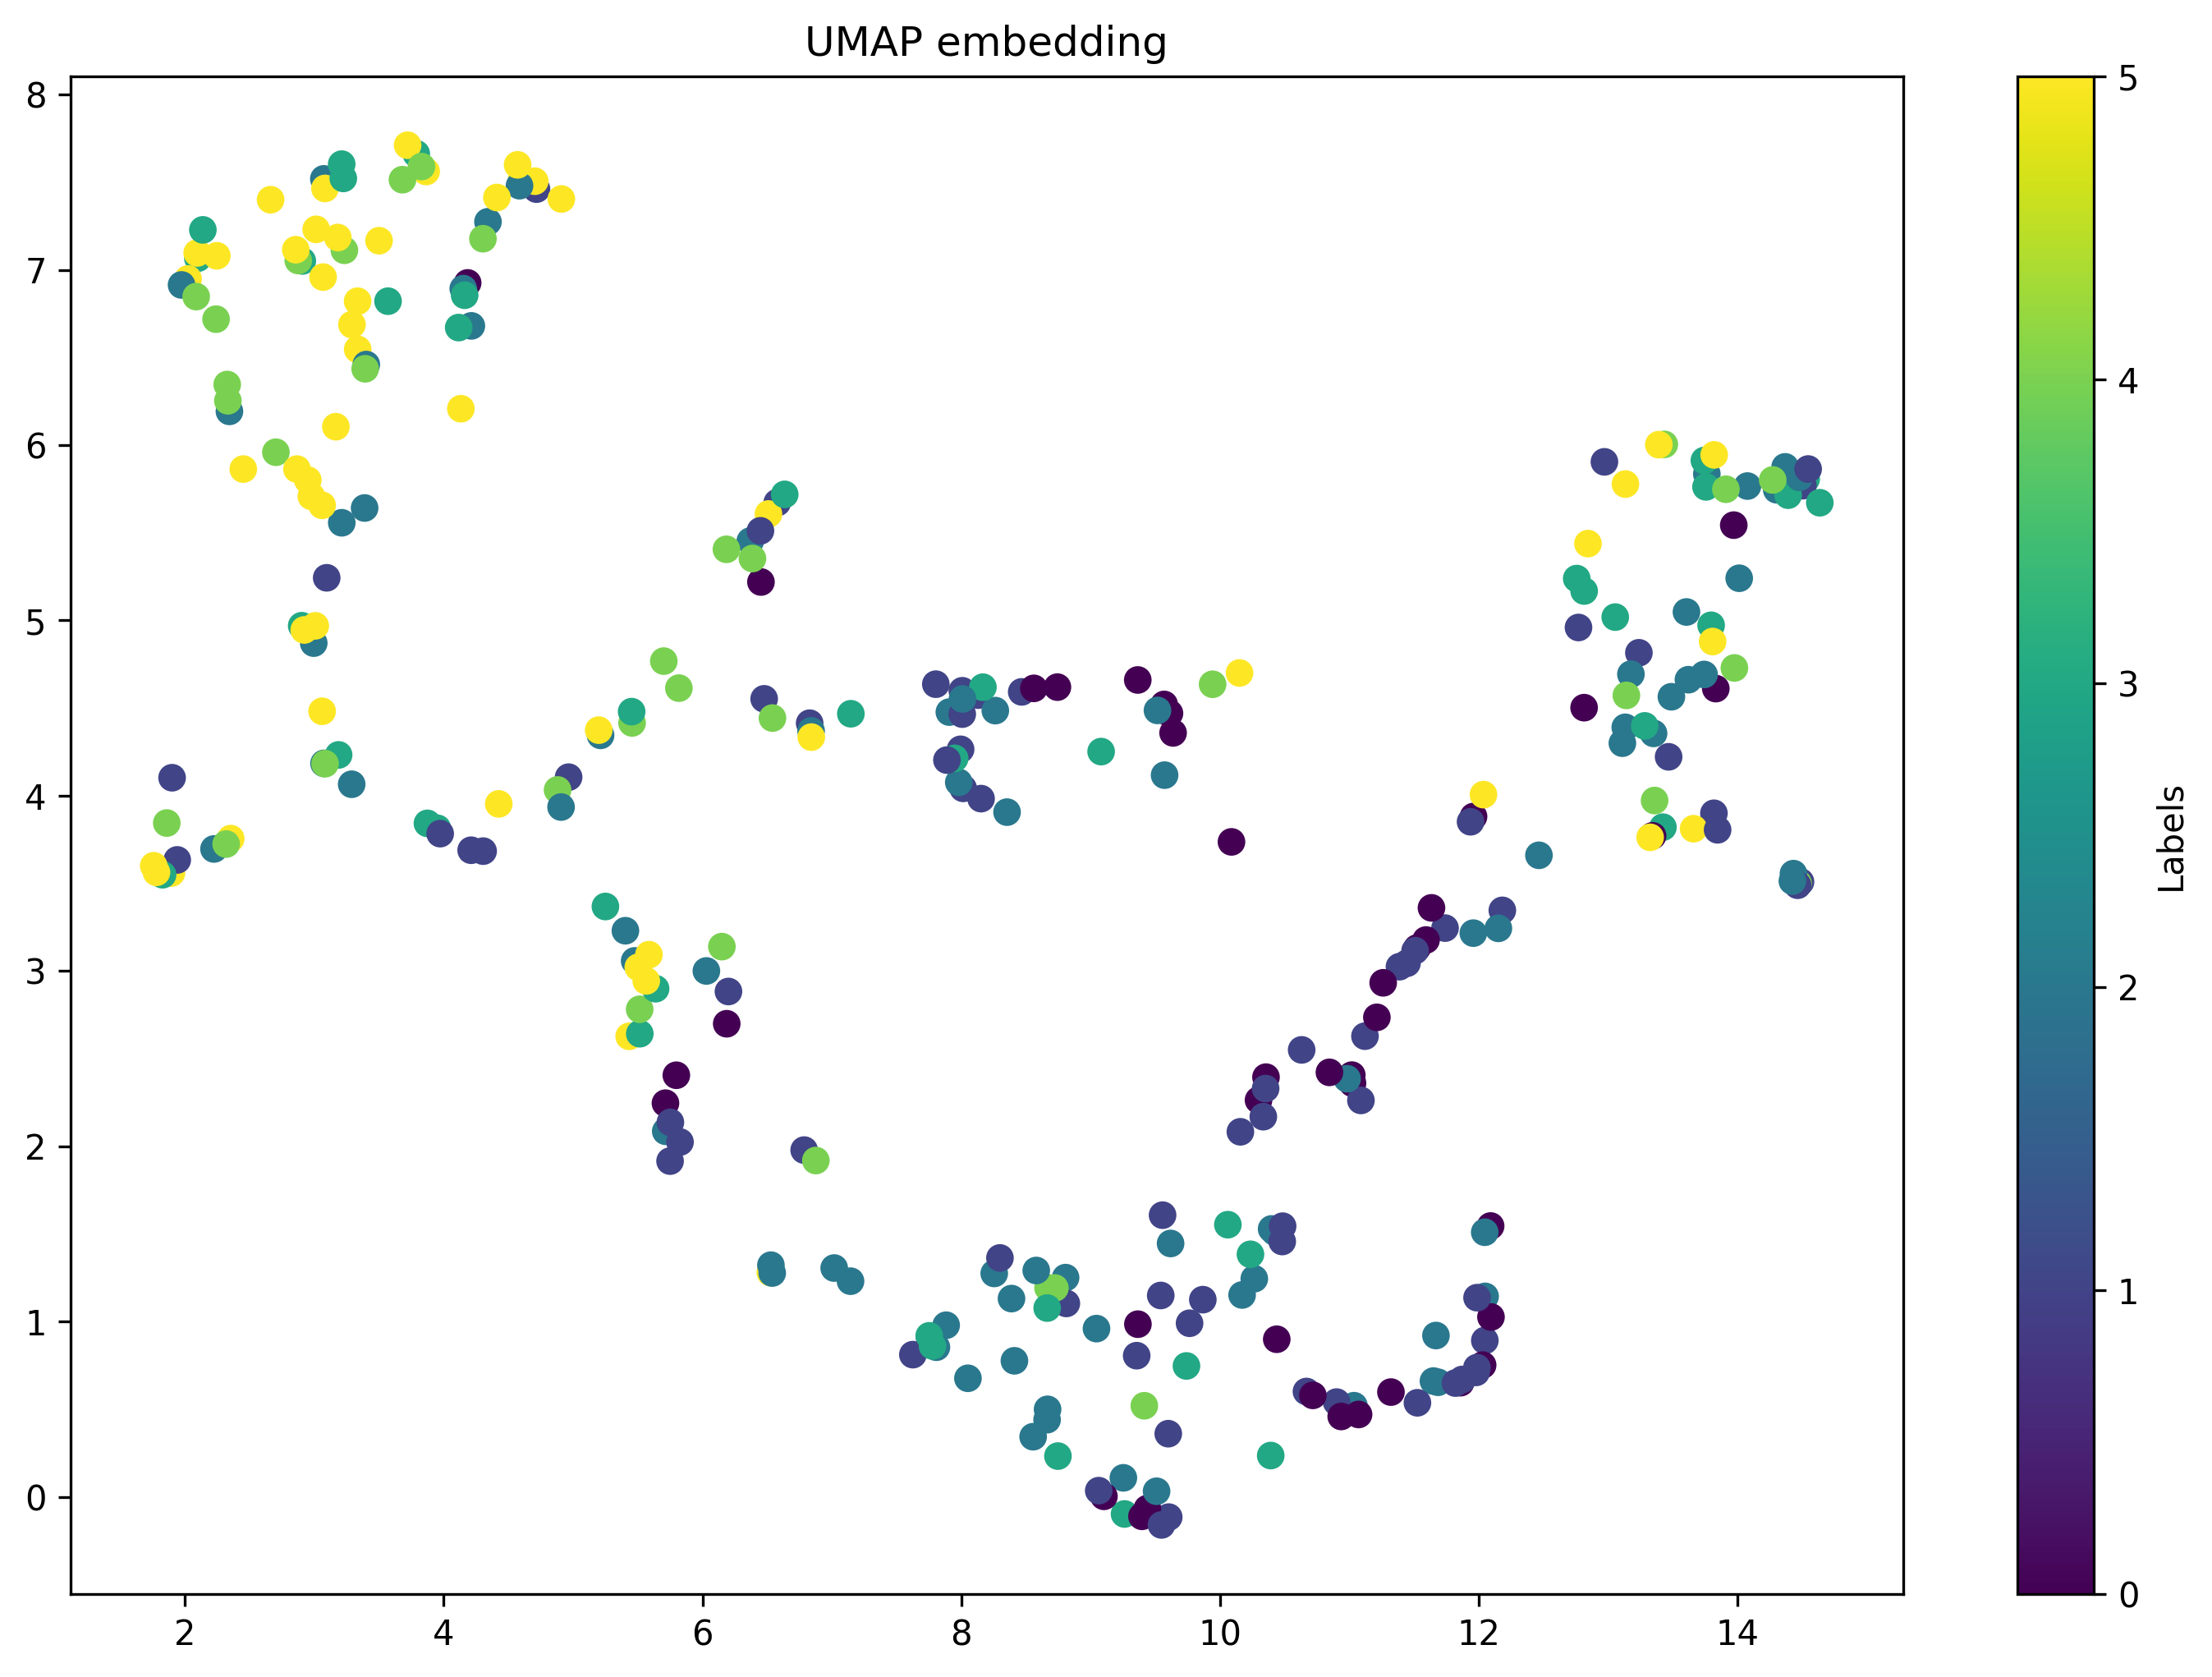

In [13]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.08, n_components=2, random_state=2024)
X_umap = umap_model.fit_transform(X_scaled)
plt.figure(figsize=(12, 8),dpi=300)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', s=50)
plt.title('UMAP embedding')
plt.colorbar(scatter, label='Labels')
plt.show()

In [14]:
!pip install cleanlab[datalab] -q
import cleanlab
from cleanlab import Datalab
from cleanlab.classification import CleanLearning
from cleanlab.benchmarking import noise_generation

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [15]:
from sklearn.model_selection import cross_val_predict
yourFavoriteModel = pipeline.named_steps['model']
pred_probs = cross_val_predict(
    estimator=yourFavoriteModel, X=X_processed_df, y=y_remapped, cv=cv, method="predict_proba"
)

In [16]:
data = pd.concat([X_processed_df, y_remapped.rename('target')], axis=1)
data

,Age,Post onset,CinMid - GM,PariInf - GM,FrSupMed - GM,TempPSup - GM,Angular - GM,TempSup - GM,Calcarine - GM,Amygdala - GM,...,FMT - WM,CC - WM,Handinf U - WM,FSL - WM,Fornix - WM,FOP - WM,Lesion volume,Gender_f,Gender_m,target
0,-0.768819,-0.073673,-0.203207,0.902184,-0.184733,1.403176,-0.662810,-0.523388,-0.159831,1.125391,...,-0.376036,0.356913,0.569642,0.985270,1.752746,-0.379820,0.336086,1.0,0.0,1
1,2.141229,-0.592614,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.237012,...,-0.376036,-1.040717,-0.883254,-0.624203,-0.528063,-0.627330,-1.042607,0.0,1.0,1
2,-1.425926,0.185798,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.905486,-0.159831,-0.580868,...,-0.376036,-1.104444,-0.883254,-0.634294,-0.473502,-0.628834,-1.113666,0.0,1.0,0
3,1.390249,-0.221941,-0.242731,-0.635777,-0.184733,-0.510315,-0.030156,-0.767974,-0.159831,-0.330770,...,-0.193987,-0.181533,-0.550093,-0.291508,-0.559278,0.541616,-0.171471,1.0,0.0,1
4,-1.425926,-0.333143,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.897648,-0.159831,-0.580868,...,-0.376036,-1.000119,-0.883254,-0.634294,-0.582362,-0.655373,-1.041443,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,-0.205584,-0.666748,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.376036,-1.131132,-0.883254,-0.634294,-0.614233,-0.655373,-1.193050,1.0,0.0,1
317,-0.205584,-0.370210,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.376036,-1.180302,-0.883254,-0.634294,-0.611216,-0.655373,-1.211883,0.0,1.0,1
318,0.076034,-0.555547,-0.242731,-0.302811,-0.184733,-0.443716,-0.712923,-0.728922,-0.117799,-0.299548,...,-0.376036,0.078066,1.211415,-0.037291,-0.598756,0.214432,0.097300,0.0,1.0,2
319,0.169906,0.259932,-0.242731,-0.761885,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.376036,-0.922321,-0.780814,-0.525893,-0.615282,-0.569439,-0.898150,1.0,0.0,1


In [17]:
lab = Datalab(data, label_name="target")
lab.find_issues(pred_probs=pred_probs, features=data)

Finding null issues ...
Finding label issues ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 99 issues found in the dataset.


In [18]:
lab.report()

Here is a summary of the different kinds of issues found in the data:

    issue_type  num_issues
         label          79
near_duplicate          19
       outlier           1

Dataset Information: num_examples: 321, num_classes: 3


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 79
Overall dataset quality in terms of this issue: 0.7944

Examples representing most severe instances of this issue:
     is_label_issue  label_score  given_label  predicted_label
8              True     0.000153            0                1
165            True     0.000427            2                1
174            True     0.000762            2                1
191            True     0.001486            0                1
176            True     0.001908            2                1


---

In [19]:
yourFavoriteModel = pipeline.named_steps['model']

cl = cleanlab.classification.CleanLearning(yourFavoriteModel, seed=42)
_ = cl.fit(X_processed_df, y_remapped)
xgbissues = cl.get_label_issues()
xgbissues

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,is_label_issue,label_quality,given_label,predicted_label,sample_weight
0,False,0.930149,1,1,1.293333
1,False,0.965193,1,1,1.293333
2,True,0.020410,0,1,0.000000
3,False,0.961470,1,1,1.293333
4,False,0.402035,0,1,2.050000
...,...,...,...,...,...
316,False,0.694535,1,1,1.293333
317,True,0.091408,1,0,0.000000
318,False,0.935278,2,2,1.343750
319,False,0.959714,1,1,1.293333


In [23]:
# One line of code. Literally.
issuesxgb = CleanLearning(yourFavoriteModel, seed=42).find_label_issues(X_processed_df, y_remapped)
issuesxgb.head()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,is_label_issue,label_quality,given_label,predicted_label
0,False,0.930149,1,1
1,False,0.965193,1,1
2,True,0.020410,0,1
3,False,0.961470,1,1
4,False,0.402035,0,1


In [24]:
lowest_quality_labels = issuesxgb["label_quality"].argsort()[:79]
lowest_quality_labels.values

array([  8, 165, 174, 191, 176, 195,  52, 184, 202,  95, 253, 102,   2,
       281, 169,  14,  92,  13, 110, 189,  44,  78,  86,   9, 270, 219,
        43, 194, 128,  37, 256,  12,   5, 317, 149,  76, 207,  87,  94,
       225, 312, 170, 213, 309, 127, 182, 200, 157, 132, 159,  97, 215,
       119, 125, 265, 113, 290, 282, 238, 115, 306,  61, 236, 117, 218,
       286, 229,   6,  99,  75,  23,   7, 263,  65, 106, 305,  34, 162,
       137])

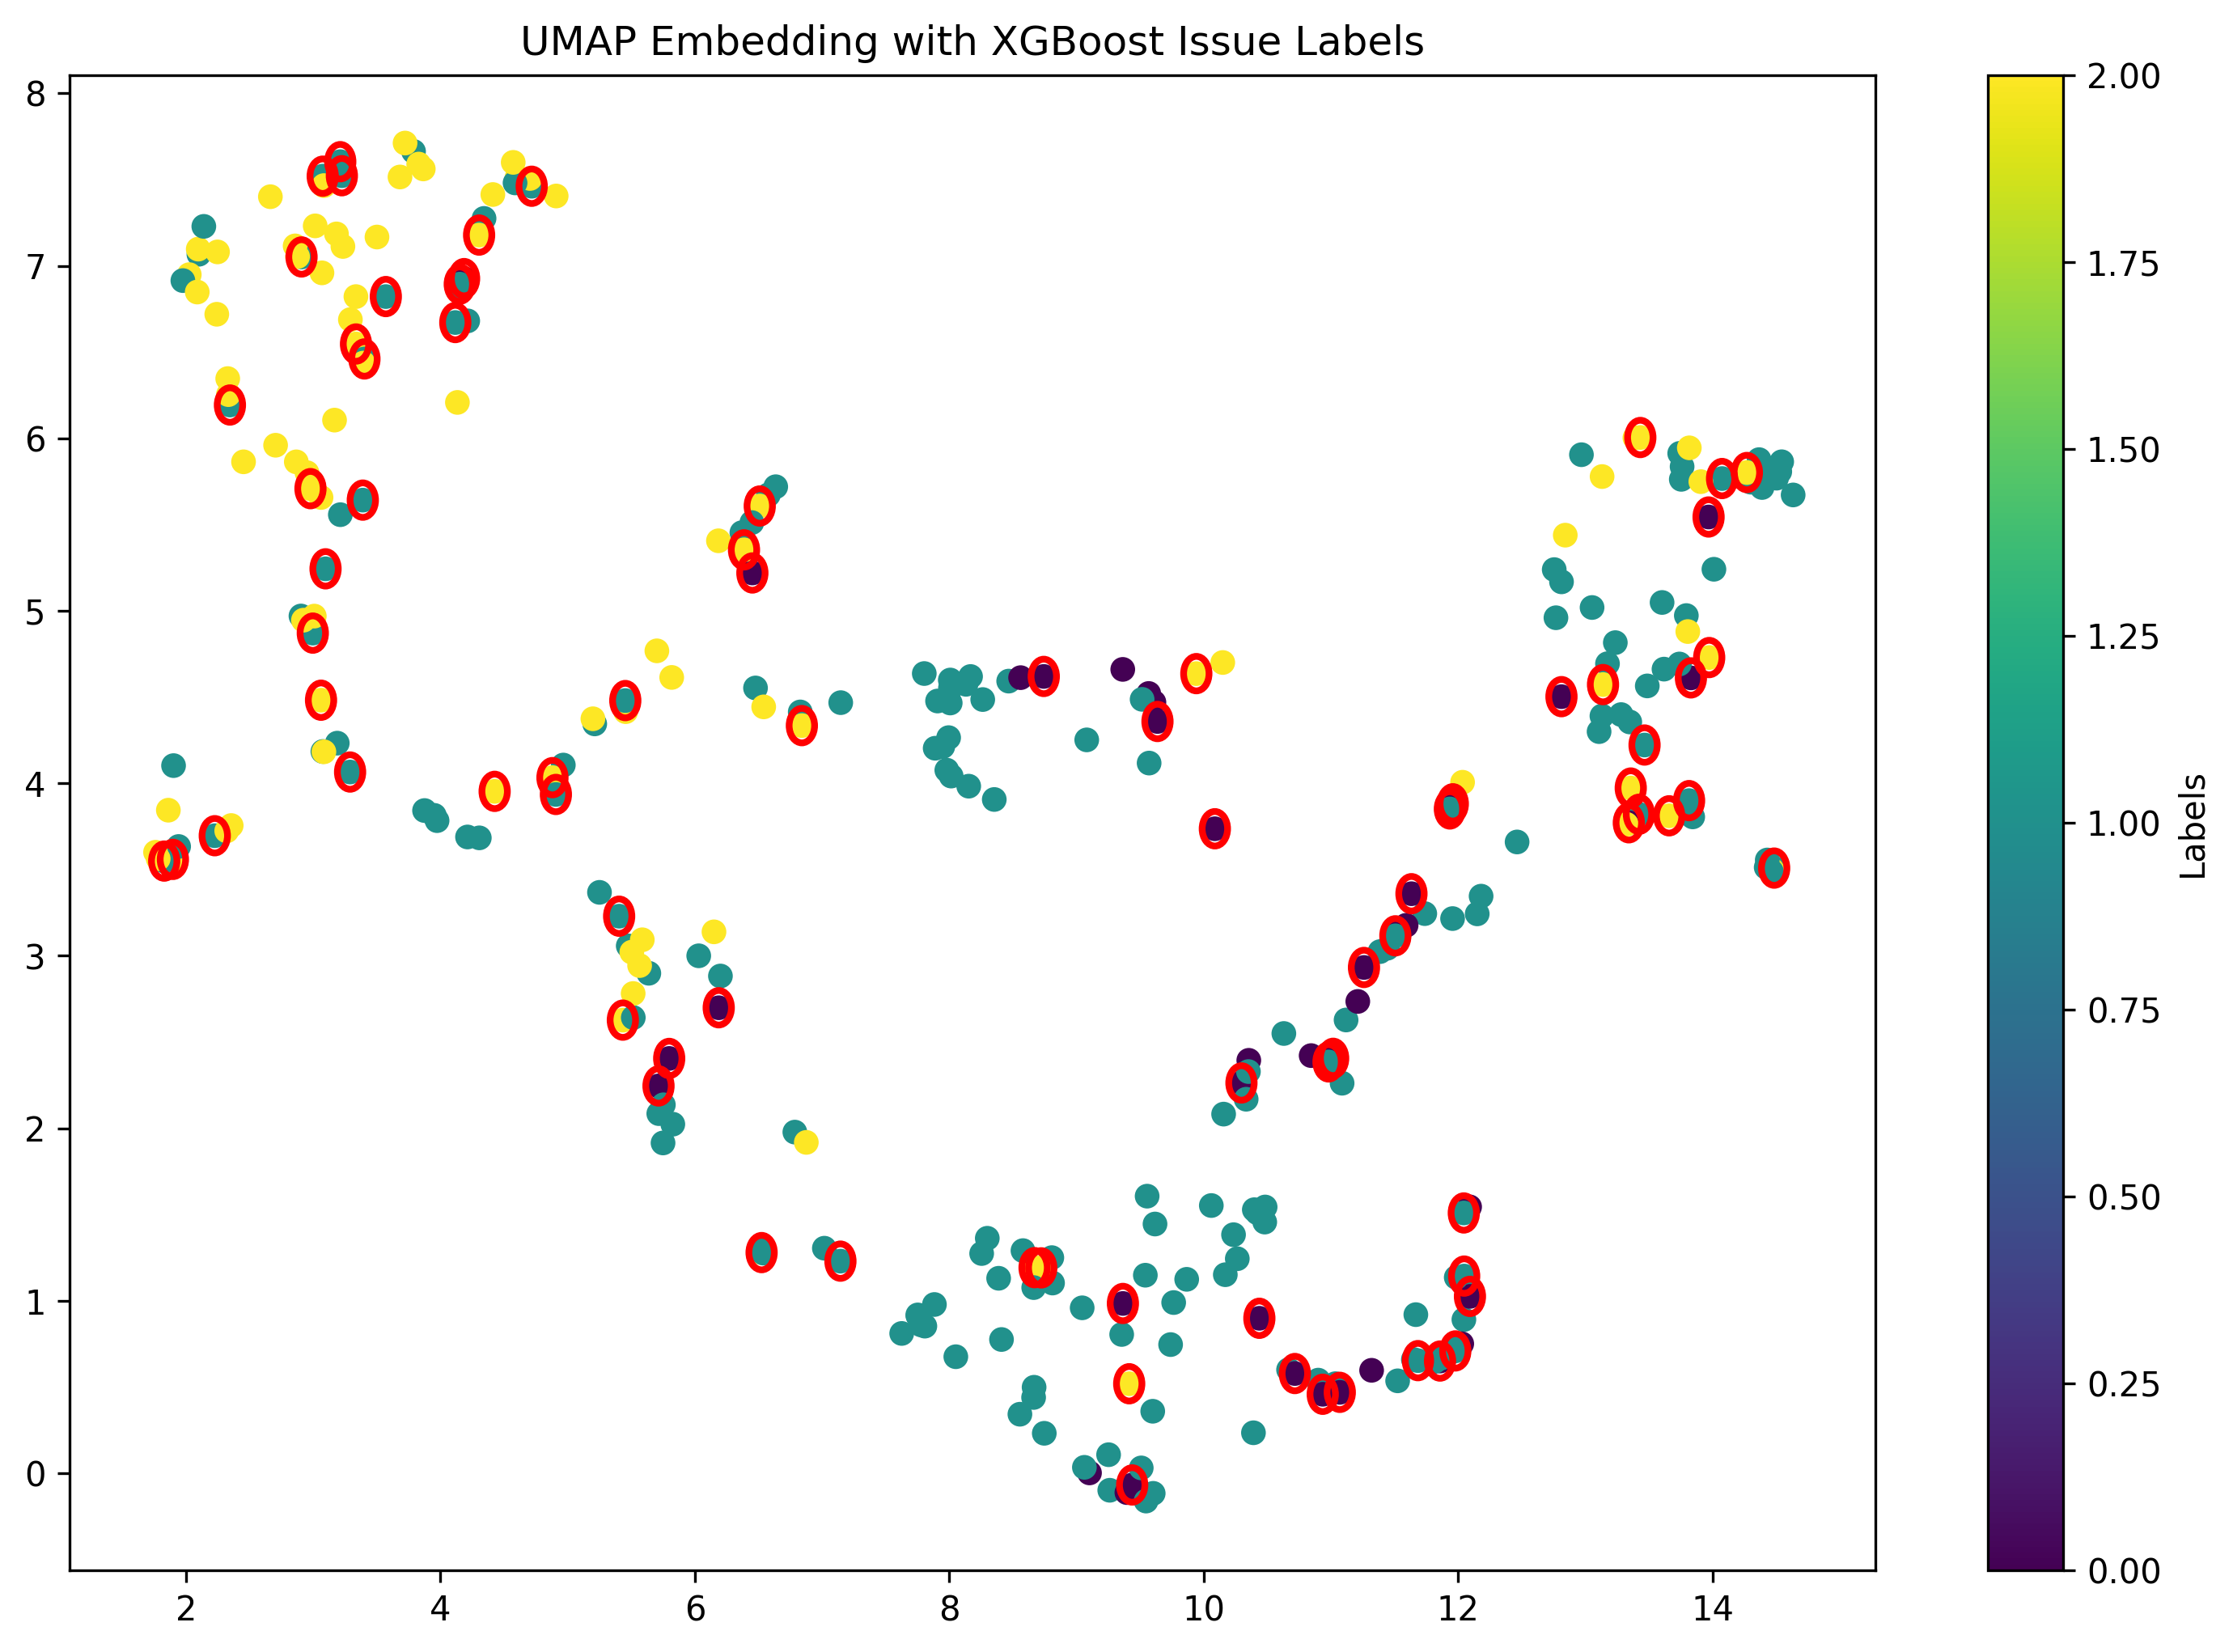

In [25]:
#umap_model = umap.UMAP(n_neighbors=5, min_dist=0.08, n_components=2, random_state=2024)
X_umap = umap_model.fit_transform(X_scaled)
plt.figure(figsize=(12, 8), dpi=300)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_remapped, cmap='viridis', s=40)
plt.title('UMAP Embedding with XGBoost Issue Labels')
plt.colorbar(scatter, label='Labels')

# Highlight the issue points with circles
for index in lowest_quality_labels:
    plt.gca().add_patch(plt.Circle((X_umap[index, 0], X_umap[index, 1]), radius=0.1, color='red', fill=False, linewidth=2))

plt.show()


In [27]:
all_results = []
misclassified_cases = []
for idx, combination in enumerate(combinations_):
    y_remapped = remap_labels(y, combination)
    params = {'booster': 'gbtree', 'lambda': 0.0006504111243096067, 'alpha': 0.0022093221198215187, 'max_depth': 10, 'learning_rate': 0.49029935492233095, 'n_estimators': 403, 'subsample': 0.4272968090040694, 'colsample_bytree': 0.7899715391834701, 'min_child_weight': 6, 'gamma': 0.4068228506620585}
    #-------------------------------------------------------------------------#
    model = xgb.XGBClassifier(**params,
                              objective="multi:softmax",
                              eval_metric="mlogloss",
                              use_label_encoder=False ,
                              random_state=seed,
                              tree_method = "hist",
                              verbosity=1)
    #-------------------------------------------------------------------------#

    pipeline = create_pipeline(model, numerical_features, categorical_features)
    analyze_results(pipeline, X, y_remapped, cv, idx, combination, misclassified_cases, plot=True, type='', error_case=True)
misclassified_cases    

[{'idx': 0,
  'combination': [[0], [1, 2, 3], [4, 5]],
  'misclassified_samples': array([  8,  12,  28,  37,  81,  95,  97, 118, 123, 125, 133, 154, 165,
         194, 213, 219, 280, 281, 312]),
  'number_wrong_cases': 19,
  'true_labels': array([0, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 0, 2, 2, 1]),
  'predicted_labels': array([1, 1, 2, 1, 0, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2],
        dtype=int32)},
 {'idx': 0,
  'combination': [[0], [1, 2, 3], [4, 5]],
  'misclassified_samples': array([  4,  45,  52,  78,  84, 102, 149, 156, 182, 198, 201, 204, 215,
         263, 265, 270]),
  'number_wrong_cases': 16,
  'true_labels': array([0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1]),
  'predicted_labels': array([1, 0, 1, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 0, 0], dtype=int32)},
 {'idx': 0,
  'combination': [[0], [1, 2, 3], [4, 5]],
  'misclassified_samples': array([  2,   9,  23,  68, 110, 126, 170, 174, 176, 189, 193, 197, 202,
         207, 236, 266, 296, 299, 305, 317, 320]),
  'n

In [39]:
issuesxgb['is_label_issue'].sum()

79

# LGBM

[2, 8, 9, 265, 270, 149, 165, 169, 44, 305, 184, 189, 317, 191, 202, 76, 78, 207, 213, 86, 87, 215, 94, 102, 236, 110, 125] 27


In [67]:
combinations_ = [combinations[16]]
combinations_

[[[0], [1, 2, 3, 4], [5]]]

In [68]:
from sklearn.pipeline import Pipeline
def create_pipeline(model, numerical_features, categorical_features):
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('encoder', OneHotEncoder())
    ])
    preprocessor = ColumnTransformer([
        ('numerical', numerical_pipeline, numerical_features),
        ('categorical', categorical_pipeline, categorical_features)
    ])
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipeline

In [69]:
for idx, combination in enumerate(combinations_):
    y_remapped = remap_labels(y, combination)
    params = {'class_weight': 'balanced', 'boosting_type': 'gbdt', 'num_leaves': 182, 'max_depth': 14, 'learning_rate': 0.0026540309077107247, 'n_estimators': 1338, 'min_child_samples': 17, 'min_child_weight': 0.6667968973274166, 'subsample': 0.031253963455450486, 'colsample_bytree': 0.7751718608430662, 'reg_alpha': 0.9370902102203016, 'reg_lambda': 0.6319453042669246}

    #-------------------------------------------------------------------------#
    model = lgb.LGBMClassifier(**params, objective='multiclass', metric='multi_logloss', verbosity=-1, random_state=seed)
    #-------------------------------------------------------------------------#

    pipeline = create_pipeline(model, numerical_features, categorical_features)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Post onset',
                                                   'CinMid - GM',
                                                   'PariInf - GM',
                                                   'FrSupMed - GM',
                                                   'TempPSup - GM',
                                                   'Angular - GM',
                                                   'TempSup - GM',
                                                   'Calcarine - GM',
                                                   'Amygdala - GM',
                                                   'RolOper - GM',
                                                   'Insula - GM', 'Heschl - GM',
                                                   'FrInfTri - GM',
                                                   'FrInfOrb - GM',
                                                   'OccInf - GM', 'OccMid - GM',
                                                   'FrMid - GM',...
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.7751718608430662,
                                learning_rate=0.0026540309077107247,
                                max_depth=14, metric='multi_logloss',
                                min_child_samples=17,
                                min_child_weight=0.6667968973274166,
                                n_estimators=1338, num_leaves=182,
                                objective='multiclass', random_state=42,
                                reg_alpha=0.9370902102203016,
                                reg_lambda=0.6319453042669246,
                                subsample=0.031253963455450486,
                                verbosity=-1))])

In [61]:
# 创建包含表格数据的 DataFrame
data = {
    "ID": [2, 8, 9, 265, 270, 149, 165, 169, 184, 189, 317, 191, 202, 76, 78, 207, 213, 86, 87, 215, 102, 236, 110, 125],
    "predicted_label": [1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0]
}

labels = pd.DataFrame(data)

# # 方法 1：随机选择数字改变 y
# for idx in labels['ID']:
#     y_remapped.iloc[idx] = np.random.choice([0, 1, 2])

# # 打印随机修改后的 y
# print("随机修改后的 y：")
# print(y_remapped[labels['ID']])

# 方法 2：根据 predicted_label 改变 y
for idx, predicted_label in zip(labels['ID'], labels['predicted_label']):
    y_remapped.iloc[idx] = predicted_label

# 打印根据 predicted_label 修改后的 y
print("根据 predicted_label 修改后的 y：")
print(y_remapped[labels['ID']])

根据 predicted_label 修改后的 y：
2      1
8      1
9      1
265    0
270    0
149    2
165    1
169    1
184    1
189    1
317    0
191    1
202    1
76     2
78     0
207    1
213    1
86     1
87     0
215    2
102    2
236    2
110    1
125    0
Name: Aphasia_severity, dtype: int64


In [70]:
all_results = []
process_results(pipeline, X, y_remapped, cv, scoring_metrics, idx, combination, params, all_results)
all_results

[{'idx': 0,
  'combination': [[0], [1, 2, 3, 4], [5]],
  'accuracy': '0.754 ± 0.051',
  'balanced_accuracy': '0.677 ± 0.048',
  'weighted_balanced_accuracy': '0.623 ± 0.058',
  'precision_macro': '0.676 ± 0.078',
  'recall_macro': '0.677 ± 0.048',
  'f1_macro': '0.666 ± 0.057',
  'f0.5_macro': '0.669 ± 0.068',
  'f2_macro': '0.670 ± 0.050',
  'best_params': {'class_weight': 'balanced',
   'boosting_type': 'gbdt',
   'num_leaves': 182,
   'max_depth': 14,
   'learning_rate': 0.0026540309077107247,
   'n_estimators': 1338,
   'min_child_samples': 17,
   'min_child_weight': 0.6667968973274166,
   'subsample': 0.031253963455450486,
   'colsample_bytree': 0.7751718608430662,
   'reg_alpha': 0.9370902102203016,
   'reg_lambda': 0.6319453042669246}}]

In [62]:
all_results = []
process_results(pipeline, X, y_remapped, cv, scoring_metrics, idx, combination, params, all_results)
all_results

[{'idx': 125,
  'combination': [[0], [1, 2, 3, 4], [5]],
  'accuracy': '0.785 ± 0.035',
  'balanced_accuracy': '0.753 ± 0.054',
  'weighted_balanced_accuracy': '0.727 ± 0.082',
  'precision_macro': '0.703 ± 0.047',
  'recall_macro': '0.753 ± 0.054',
  'f1_macro': '0.717 ± 0.041',
  'f0.5_macro': '0.706 ± 0.042',
  'f2_macro': '0.735 ± 0.047',
  'best_params': {'class_weight': 'balanced',
   'boosting_type': 'gbdt',
   'num_leaves': 182,
   'max_depth': 14,
   'learning_rate': 0.0026540309077107247,
   'n_estimators': 1338,
   'min_child_samples': 17,
   'min_child_weight': 0.6667968973274166,
   'subsample': 0.031253963455450486,
   'colsample_bytree': 0.7751718608430662,
   'reg_alpha': 0.9370902102203016,
   'reg_lambda': 0.6319453042669246}}]

In [43]:
pipeline.fit(X,y_remapped)
X_processed = pipeline.named_steps['preprocessor'].transform(X)
categorical_encoder = pipeline.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['encoder']
encoded_categorical_features = categorical_encoder.get_feature_names_out(input_features=categorical_features)
processed_feature_names = numerical_features + list(encoded_categorical_features)
X_processed_df = pd.DataFrame(X_processed, columns=processed_feature_names)
X_processed_df

,Age,Post onset,CinMid - GM,PariInf - GM,FrSupMed - GM,TempPSup - GM,Angular - GM,TempSup - GM,Calcarine - GM,Amygdala - GM,...,SLF-I - WM,FMT - WM,CC - WM,Handinf U - WM,FSL - WM,Fornix - WM,FOP - WM,Lesion volume,Gender_f,Gender_m
0,-0.768819,-0.073673,-0.203207,0.902184,-0.184733,1.403176,-0.662810,-0.523388,-0.159831,1.125391,...,0.764118,-0.376036,0.356913,0.569642,0.985270,1.752746,-0.379820,0.336086,1.0,0.0
1,2.141229,-0.592614,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.237012,...,-0.666467,-0.376036,-1.040717,-0.883254,-0.624203,-0.528063,-0.627330,-1.042607,0.0,1.0
2,-1.425926,0.185798,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.905486,-0.159831,-0.580868,...,-0.679395,-0.376036,-1.104444,-0.883254,-0.634294,-0.473502,-0.628834,-1.113666,0.0,1.0
3,1.390249,-0.221941,-0.242731,-0.635777,-0.184733,-0.510315,-0.030156,-0.767974,-0.159831,-0.330770,...,-0.478163,-0.193987,-0.181533,-0.550093,-0.291508,-0.559278,0.541616,-0.171471,1.0,0.0
4,-1.425926,-0.333143,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.897648,-0.159831,-0.580868,...,-0.679395,-0.376036,-1.000119,-0.883254,-0.634294,-0.582362,-0.655373,-1.041443,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,-0.205584,-0.666748,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.679317,-0.376036,-1.131132,-0.883254,-0.634294,-0.614233,-0.655373,-1.193050,1.0,0.0
317,-0.205584,-0.370210,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.679395,-0.376036,-1.180302,-0.883254,-0.634294,-0.611216,-0.655373,-1.211883,0.0,1.0
318,0.076034,-0.555547,-0.242731,-0.302811,-0.184733,-0.443716,-0.712923,-0.728922,-0.117799,-0.299548,...,-0.302318,-0.376036,0.078066,1.211415,-0.037291,-0.598756,0.214432,0.097300,0.0,1.0
319,0.169906,0.259932,-0.242731,-0.761885,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.522708,-0.376036,-0.922321,-0.780814,-0.525893,-0.615282,-0.569439,-0.898150,1.0,0.0


In [44]:
data = pd.concat([X_processed_df, y_remapped.rename('target')], axis=1)
data

,Age,Post onset,CinMid - GM,PariInf - GM,FrSupMed - GM,TempPSup - GM,Angular - GM,TempSup - GM,Calcarine - GM,Amygdala - GM,...,FMT - WM,CC - WM,Handinf U - WM,FSL - WM,Fornix - WM,FOP - WM,Lesion volume,Gender_f,Gender_m,target
0,-0.768819,-0.073673,-0.203207,0.902184,-0.184733,1.403176,-0.662810,-0.523388,-0.159831,1.125391,...,-0.376036,0.356913,0.569642,0.985270,1.752746,-0.379820,0.336086,1.0,0.0,1
1,2.141229,-0.592614,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.237012,...,-0.376036,-1.040717,-0.883254,-0.624203,-0.528063,-0.627330,-1.042607,0.0,1.0,1
2,-1.425926,0.185798,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.905486,-0.159831,-0.580868,...,-0.376036,-1.104444,-0.883254,-0.634294,-0.473502,-0.628834,-1.113666,0.0,1.0,0
3,1.390249,-0.221941,-0.242731,-0.635777,-0.184733,-0.510315,-0.030156,-0.767974,-0.159831,-0.330770,...,-0.193987,-0.181533,-0.550093,-0.291508,-0.559278,0.541616,-0.171471,1.0,0.0,1
4,-1.425926,-0.333143,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.897648,-0.159831,-0.580868,...,-0.376036,-1.000119,-0.883254,-0.634294,-0.582362,-0.655373,-1.041443,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,-0.205584,-0.666748,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.376036,-1.131132,-0.883254,-0.634294,-0.614233,-0.655373,-1.193050,1.0,0.0,1
317,-0.205584,-0.370210,-0.242731,-0.763235,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.376036,-1.180302,-0.883254,-0.634294,-0.611216,-0.655373,-1.211883,0.0,1.0,1
318,0.076034,-0.555547,-0.242731,-0.302811,-0.184733,-0.443716,-0.712923,-0.728922,-0.117799,-0.299548,...,-0.376036,0.078066,1.211415,-0.037291,-0.598756,0.214432,0.097300,0.0,1.0,2
319,0.169906,0.259932,-0.242731,-0.761885,-0.184733,-0.669410,-0.712923,-0.918448,-0.159831,-0.580868,...,-0.376036,-0.922321,-0.780814,-0.525893,-0.615282,-0.569439,-0.898150,1.0,0.0,1


In [45]:
from sklearn.model_selection import cross_val_predict
yourFavoriteModel = pipeline.named_steps['model']
pred_probs = cross_val_predict(
    estimator=yourFavoriteModel, X=X_processed_df, y=y_remapped, cv=cv, method="predict_proba"
)

In [46]:
lab = Datalab(data, label_name="target")
lab.find_issues(pred_probs=pred_probs, features=data)

Finding null issues ...
Finding label issues ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 84 issues found in the dataset.


In [47]:
lab.report()

Here is a summary of the different kinds of issues found in the data:

    issue_type  num_issues
         label          64
near_duplicate          19
       outlier           1

Dataset Information: num_examples: 321, num_classes: 3


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 64
Overall dataset quality in terms of this issue: 0.8411

Examples representing most severe instances of this issue:
     is_label_issue  label_score  given_label  predicted_label
165            True     0.026972            2                1
225            True     0.028333            2                1
9              True     0.043109            0                1
78             True     0.047440            1                0
202            True     0.051067            2                1


---

In [48]:
yourFavoriteModel = pipeline.named_steps['model']
cl = cleanlab.classification.CleanLearning(yourFavoriteModel, seed=42)
_ = cl.fit(X_processed_df, y_remapped)
lgbissues = cl.get_label_issues()
lgbissues

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,is_label_issue,label_quality,given_label,predicted_label,sample_weight
0,False,0.854808,1,1,1.130435
1,False,0.616477,1,1,1.130435
2,True,0.181430,0,1,0.000000
3,False,0.749665,1,1,1.130435
4,True,0.280140,0,1,0.000000
...,...,...,...,...,...
316,True,0.242911,1,0,0.000000
317,True,0.089545,1,0,0.000000
318,True,0.086303,2,1,0.000000
319,False,0.756741,1,1,1.130435


In [49]:
# One line of code. Literally.
issueslgb = CleanLearning(yourFavoriteModel, seed=42).find_label_issues(X_processed_df, y_remapped)
issueslgb.head()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,is_label_issue,label_quality,given_label,predicted_label
0,False,0.854808,1,1
1,False,0.616477,1,1
2,True,0.181430,0,1
3,False,0.749665,1,1
4,True,0.280140,0,1


In [50]:
issueslgb['is_label_issue'].sum()

64

In [51]:
lowest_quality_labels = issueslgb["label_quality"].argsort()[:64]
lowest_quality_labels

0     165
1     225
2       9
3      78
4     202
     ... 
59    227
60    201
61    162
62    125
63    265
Name: label_quality, Length: 64, dtype: int64

In [52]:
lowest_quality_labels.values

array([165, 225,   9,  78, 202, 192,  44, 306, 221, 318, 216, 317, 128,
       273,  87, 260, 197, 115, 207, 270, 191, 122,   2, 282,   8, 172,
       236, 120, 102, 154, 305, 274, 189, 246, 307, 193, 316, 217, 213,
       203, 108,  92,   4, 211,  94, 233,  91, 110, 169, 284, 242, 302,
       118, 268, 215, 184, 149,  86,  76, 227, 201, 162, 125, 265])

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


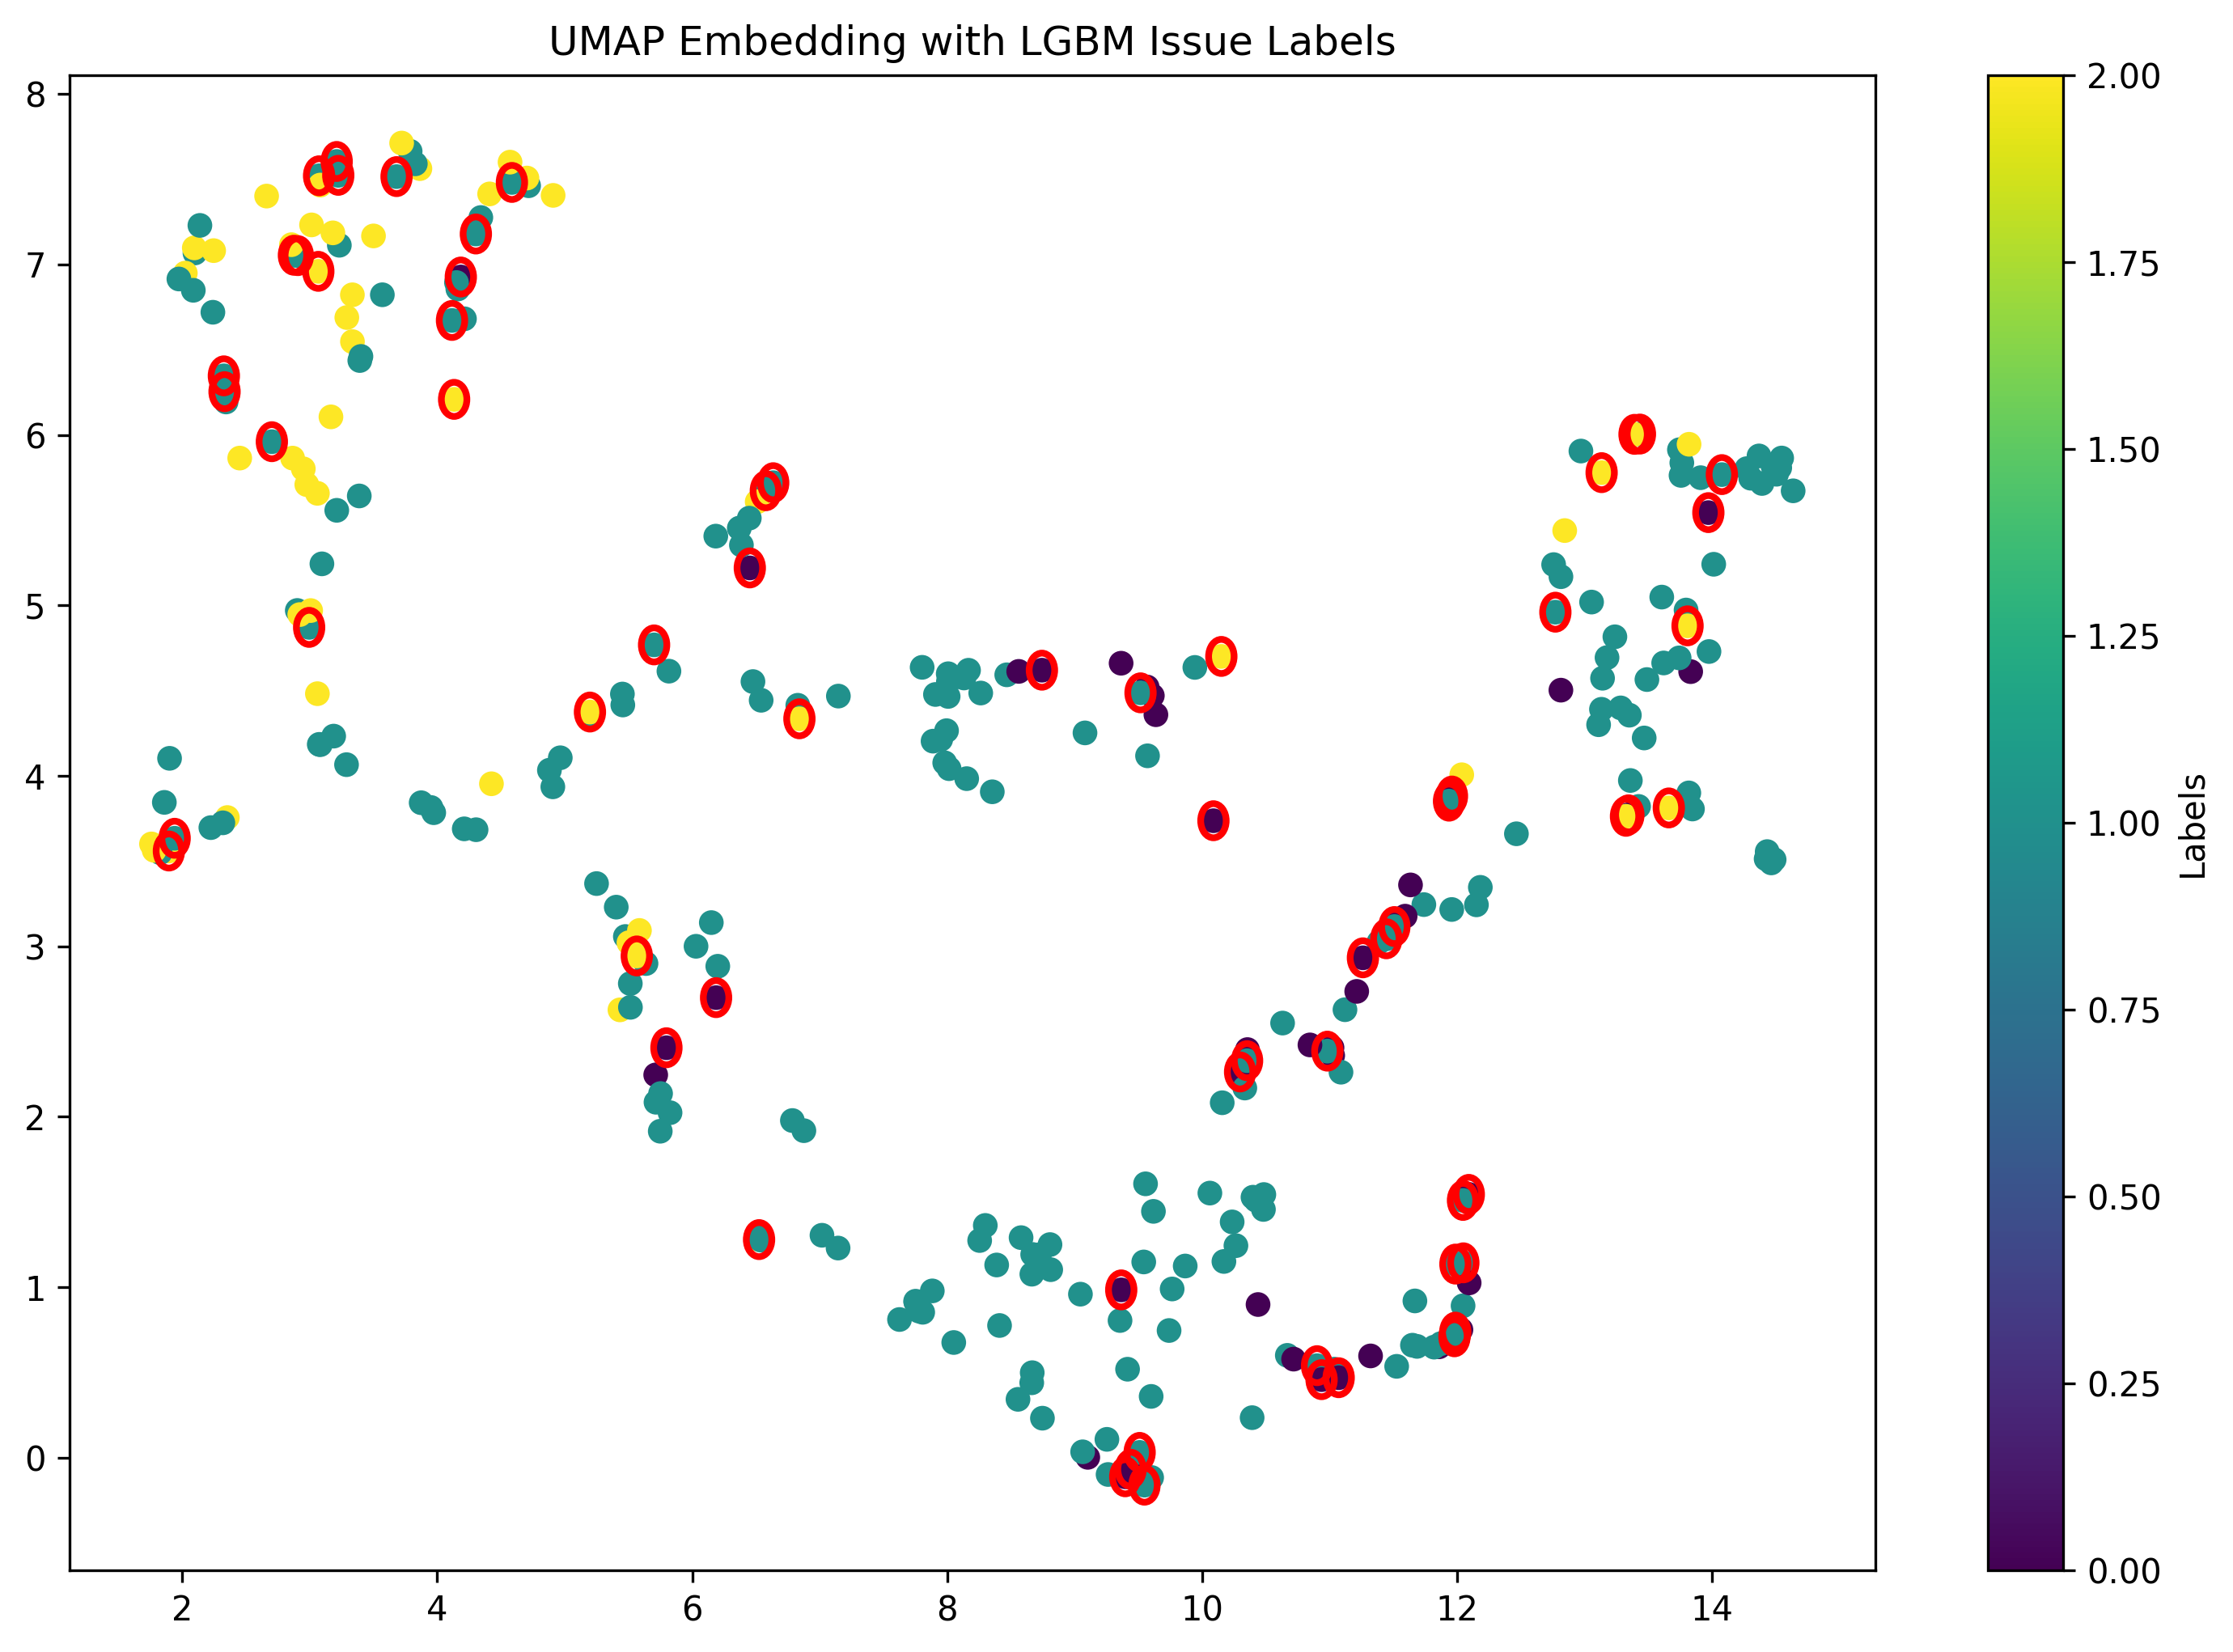

In [53]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.08, n_components=2, random_state=2024)
X_umap = umap_model.fit_transform(X_processed_df)
plt.figure(figsize=(12, 8), dpi=300)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_remapped, cmap='viridis', s=40)
plt.title('UMAP Embedding with LGBM Issue Labels')
plt.colorbar(scatter, label='Labels')

# Highlight the issue points with circles
for index in lowest_quality_labels:
    plt.gca().add_patch(plt.Circle((X_umap[index, 0], X_umap[index, 1]), radius=0.1, color='red', fill=False, linewidth=2))

plt.show()


In [54]:
all_results = []
misclassified_cases = []
for idx, combination in enumerate(combinations_):
    y_remapped = remap_labels(y, combination)
    params = {'class_weight': 'balanced', 'boosting_type': 'gbdt', 'num_leaves': 182, 'max_depth': 14, 'learning_rate': 0.0026540309077107247, 'n_estimators': 1338, 'min_child_samples': 17, 'min_child_weight': 0.6667968973274166, 'subsample': 0.031253963455450486, 'colsample_bytree': 0.7751718608430662, 'reg_alpha': 0.9370902102203016, 'reg_lambda': 0.6319453042669246}

    #-------------------------------------------------------------------------#
    model = lgb.LGBMClassifier(**params, objective='multiclass', metric='multi_logloss', verbosity=-1, random_state=seed)
    #-------------------------------------------------------------------------#

    pipeline = create_pipeline(model, numerical_features, categorical_features)
    analyze_results(pipeline, X, y_remapped, cv, idx, combination, misclassified_cases, plot=True, type='', error_case=True)
misclassified_cases    

[{'idx': 0,
  'combination': [[0], [1, 2, 3, 4], [5]],
  'misclassified_samples': array([  8, 104, 108, 122, 132, 137, 162, 184, 202, 236, 284, 302, 309,
         316]),
  'number_wrong_cases': 14,
  'true_labels': array([0, 1, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 2, 1]),
  'predicted_labels': array([1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0])},
 {'idx': 0,
  'combination': [[0], [1, 2, 3, 4], [5]],
  'misclassified_samples': array([ 44,  61,  76,  91,  94,  95, 125, 128, 189, 195, 221, 225, 227,
         232, 242, 246, 260, 265, 273, 274, 314]),
  'number_wrong_cases': 21,
  'true_labels': array([0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1]),
  'predicted_labels': array([2, 2, 2, 0, 2, 1, 0, 1, 1, 2, 2, 1, 1, 2, 0, 1, 0, 0, 2, 0, 2])},
 {'idx': 0,
  'combination': [[0], [1, 2, 3, 4], [5]],
  'misclassified_samples': array([  9,  87, 115, 118, 175, 179, 188, 192, 193, 207, 306, 317]),
  'number_wrong_cases': 12,
  'true_labels': array([0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 1]),
  

In [ ]:
[  8, 104, 108, 122, 132, 137, 162, 184, 202, 236, 284, 302, 309,
         316, 44,  61,  76,  91,  94,  95, 125, 128, 189, 195, 221, 225, 227,
         232, 242, 246, 260, 265, 273, 274, 314, 9,  87, 115, 118, 175, 179, 188, 192, 193, 207, 306, 317, 2,   4,  28,  86, 120, 124, 149, 172, 191, 197, 201, 203, 215,
         318, 46,  78,  92, 102, 110, 154, 165, 169, 211, 213, 216, 217, 233,
         268, 270, 282, 305, 307]

# Overall

In [57]:
#misclassxgb
array1 = [  8,  12,  28,  37,  81,  95,  97, 118, 123, 125, 133, 154, 165,
         194, 213, 219, 280, 281, 312, 4,  45,  52,  78,  84, 102, 149, 156, 182, 198, 201, 204, 215,
         263, 265, 270, 2,   9,  23,  68, 110, 126, 170, 174, 176, 189, 193, 197, 202,
         207, 236, 266, 296, 299, 305, 317, 320, 5,  13,  16,  34, 100, 117, 132, 136, 137, 148, 169, 179, 185,
         238, 256, 14,  43,  44,  76,  86,  87,  94, 119, 184, 191, 192, 195, 200,
         221, 233, 253]

#misclasslgb
array2 = [  8, 104, 108, 122, 132, 137, 162, 184, 202, 236, 284, 302, 309,
         316, 44,  61,  76,  91,  94,  95, 125, 128, 189, 195, 221, 225, 227,
         232, 242, 246, 260, 265, 273, 274, 314, 9,  87, 115, 118, 175, 179, 188, 192, 193, 207, 306, 317, 2,   4,  28,  86, 120, 124, 149, 172, 191, 197, 201, 203, 215,
         318, 46,  78,  92, 102, 110, 154, 165, 169, 211, 213, 216, 217, 233,
         268, 270, 282, 305, 307]


#issuesxgb
array3 = [  8, 165, 174, 191, 176, 195,  52, 184, 202,  95, 253, 102,   2,
       281, 169,  14,  92,  13, 110, 189,  44,  78,  86,   9, 270, 219,
        43, 194, 128,  37, 256,  12,   5, 317, 149,  76, 207,  87,  94,
       225, 312, 170, 213, 309, 127, 182, 200, 157, 132, 159,  97, 215,
       119, 125, 265, 113, 290, 282, 238, 115, 306,  61, 236, 117, 218,
       286, 229,   6,  99,  75,  23,   7, 263,  65, 106, 305,  34, 162,
       137]

#issueslgb
array4 = [165, 225,   9,  78, 202, 192,  44, 306, 221, 318, 216, 317, 128,
       273,  87, 260, 197, 115, 207, 270, 191, 122,   2, 282,   8, 172,
       236, 120, 102, 154, 305, 274, 189, 246, 307, 193, 316, 217, 213,
       203, 108,  92,   4, 211,  94, 233,  91, 110, 169, 284, 242, 302,
       118, 268, 215, 184, 149,  86,  76, 227, 201, 162, 125, 265]

#commonmiss
array5= [2, 4, 132, 8, 9, 137, 265, 270, 149, 154, 28, 165, 169, 44, 305, 179, 184, 189, 317, 191, 192, 193, 195, 197, 201, 202, 76, 78, 207, 213, 86, 87, 215, 221, 94, 95, 102, 233, 236, 110, 118, 125]

#commonissus
array6 = [128, 2, 8, 9, 265, 270, 149, 282, 162, 165, 169, 44, 305, 306, 184, 189, 317, 191, 202, 76, 78, 207, 213, 86, 87, 215, 92, 94, 225, 102, 236, 110, 115, 125]

# Convert lists to sets
set1 = set(array1)
set2 = set(array2) 
set3 = set(array3)
set4 = set(array4)
set5 = set(array5)
set6 = set(array6)

# Find the intersection
common_numbers = set5.intersection(set6)

# Convert the set back to a list (if needed) and sort it
common_numbers = (list(common_numbers))

print(common_numbers, len(common_numbers))

[2, 8, 9, 265, 270, 149, 165, 169, 44, 305, 184, 189, 317, 191, 202, 76, 78, 207, 213, 86, 87, 215, 94, 102, 236, 110, 125] 27


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


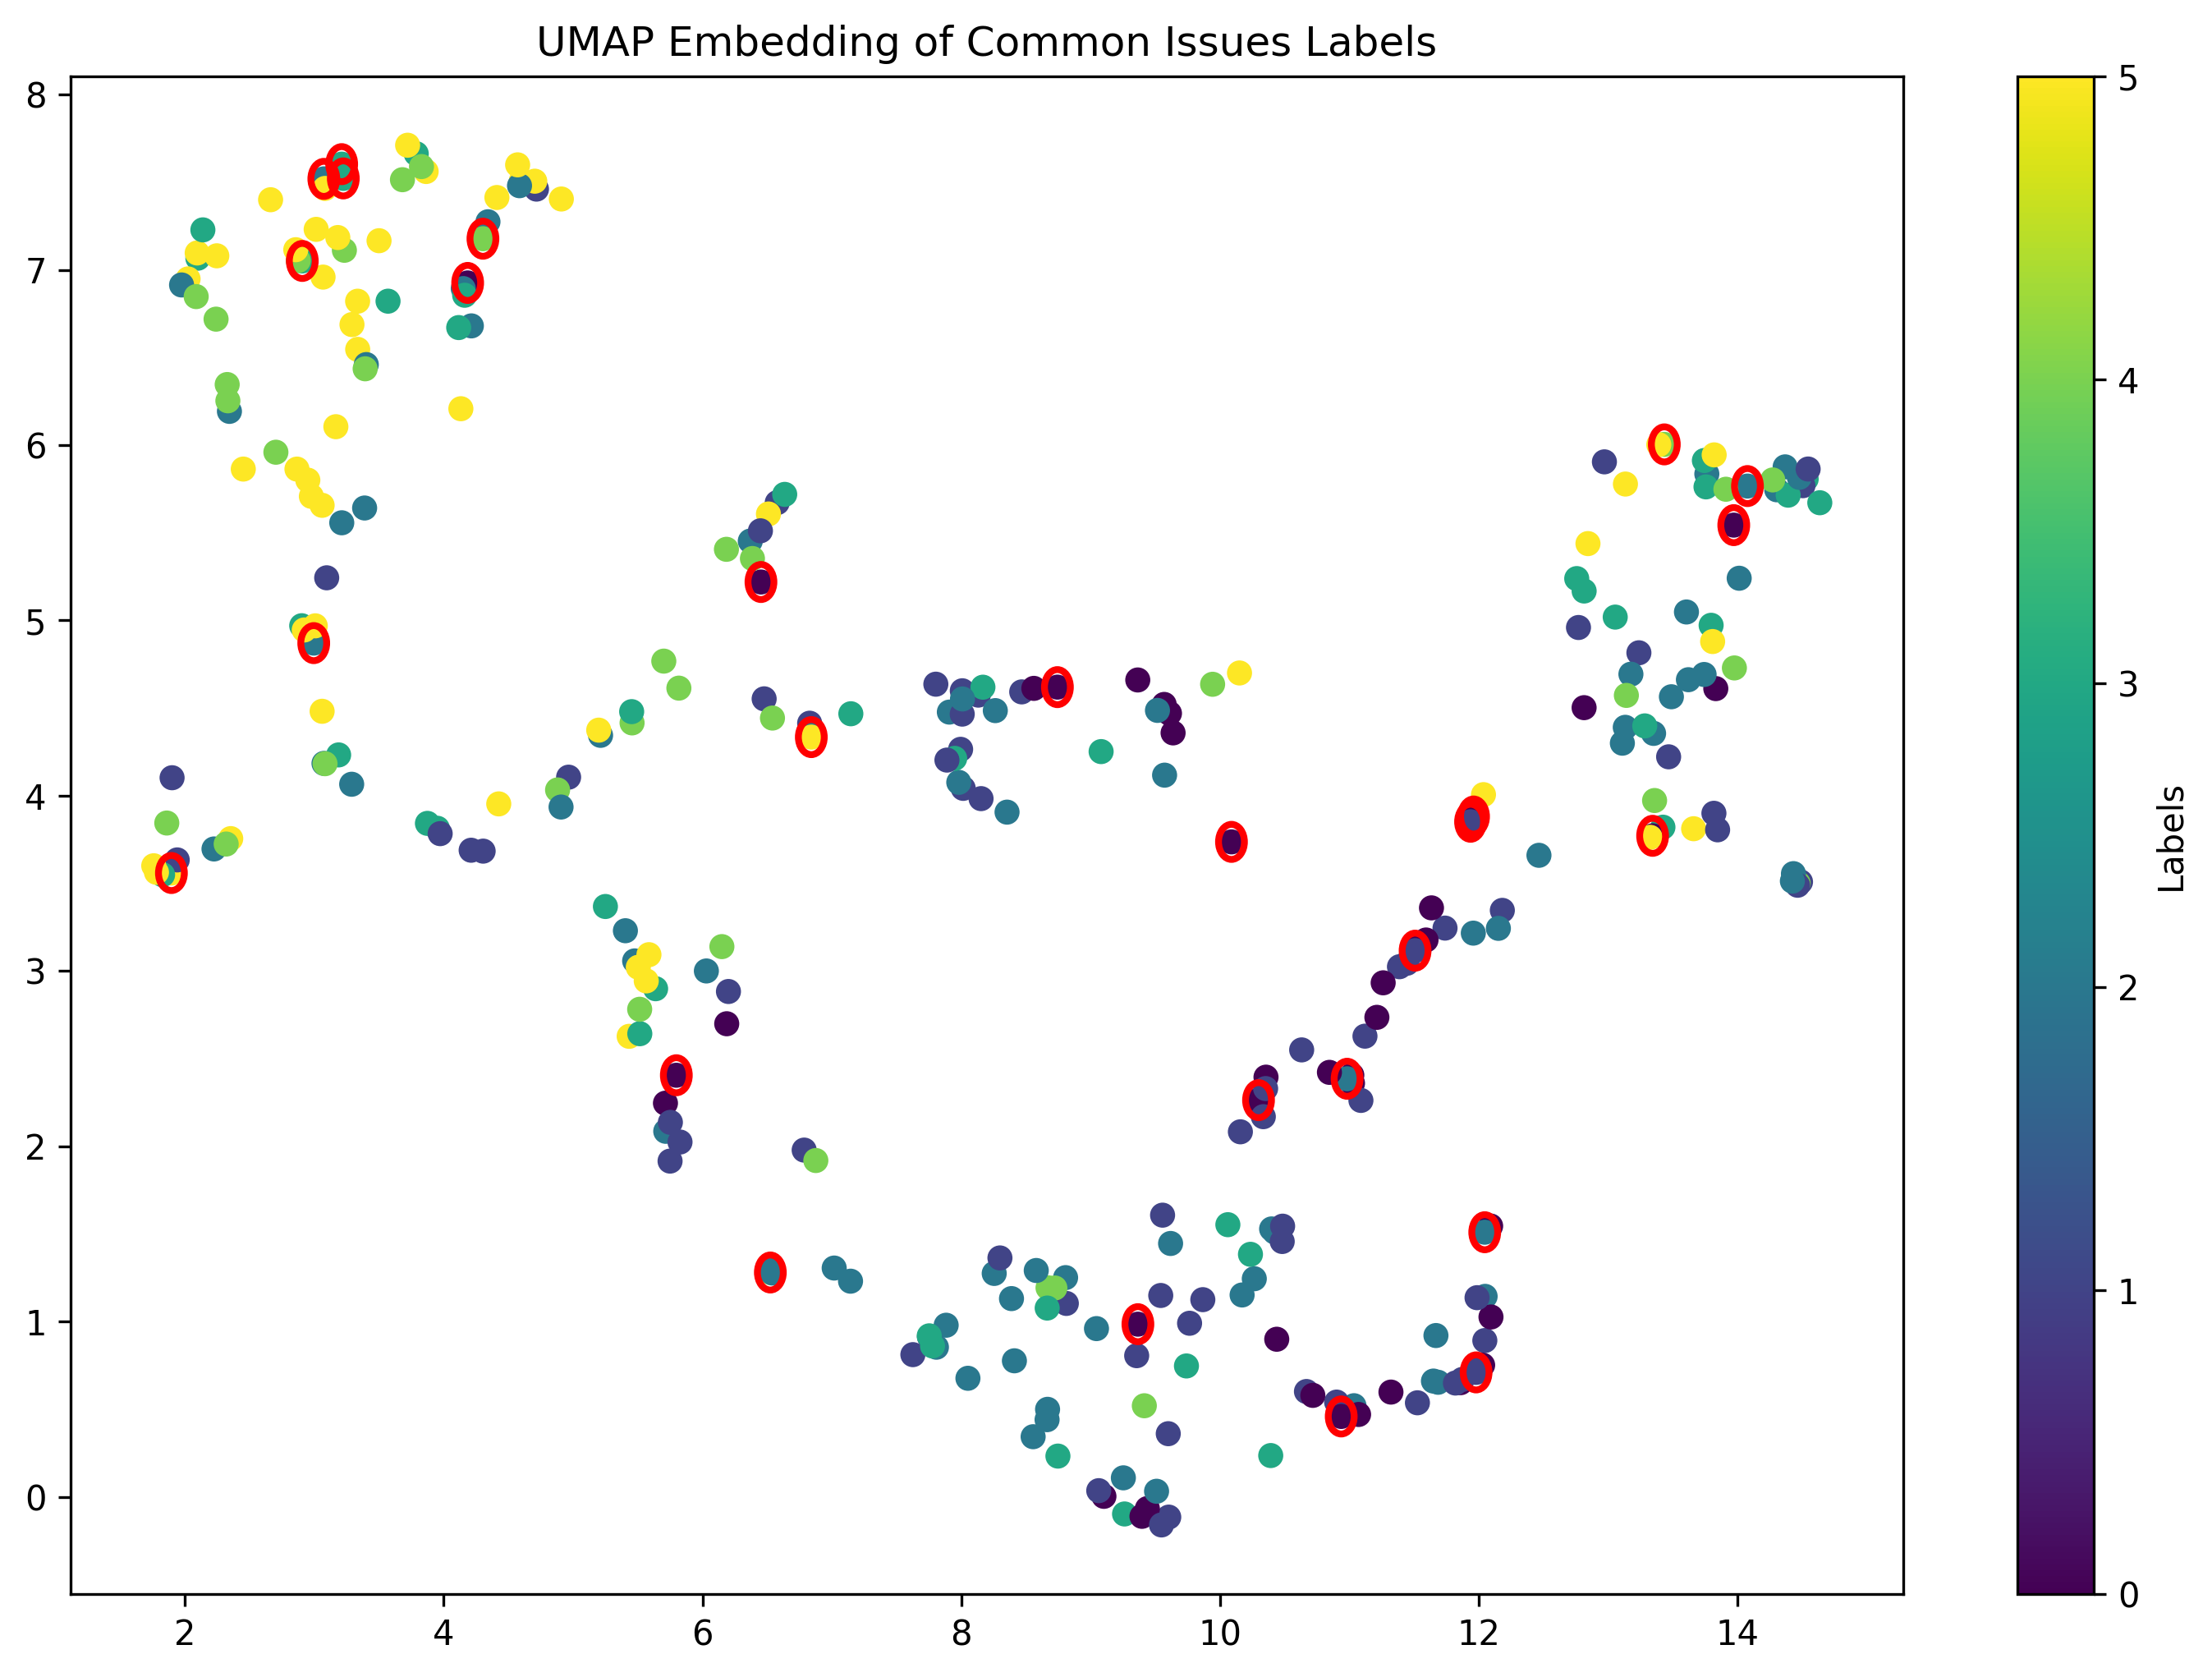

In [58]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.08, n_components=2, random_state=2024)
X_umap = umap_model.fit_transform(X_scaled)
plt.figure(figsize=(12, 8), dpi=300)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', s=40)
plt.title('UMAP Embedding of Common Issues Labels')
plt.colorbar(scatter, label='Labels')

# Highlight the issue points with circles
for index in common_numbers:
    plt.gca().add_patch(plt.Circle((X_umap[index, 0], X_umap[index, 1]), radius=0.1, color='red', fill=False, linewidth=2))

plt.show()


In [59]:
selected_rows1 = issueslgb.loc[common_numbers]
selected_rows1

,is_label_issue,label_quality,given_label,predicted_label
2,True,0.181430,0,1
8,True,0.195480,0,1
9,True,0.043109,0,1
265,True,0.382794,1,0
270,True,0.174279,1,0
149,True,0.366800,1,2
165,True,0.026972,2,1
169,False,0.313722,0,1
44,True,0.063807,0,1
305,True,0.219911,1,2


In [60]:
selected_rows2 = issuesxgb.loc[common_numbers]
selected_rows2

,is_label_issue,label_quality,given_label,predicted_label
2,True,0.020410,0,1
8,True,0.000153,0,1
9,True,0.055295,0,1
265,True,0.209134,1,0
270,True,0.055365,1,0
149,True,0.097727,1,2
165,True,0.000427,2,1
169,True,0.034096,0,1
44,False,0.050352,0,2
305,True,0.347292,2,1


In [61]:
columns_to_compare = ['given_label', 'predicted_label']

# Function to compare the rows
def compare_rows(df1, df2, columns):
    comparison_results = []
    for index in df1.index:
        row_result = {'index': index}
        for column in columns:
            value1 = df1.loc[index, column]
            value2 = df2.loc[index, column]
            row_result[column] = (value1 == value2)
        comparison_results.append(row_result)
    return pd.DataFrame(comparison_results)

# Perform the comparison
comparison_results = compare_rows(selected_rows1, selected_rows2, columns_to_compare)

comparison_results

,index,given_label,predicted_label
0,2,True,True
1,8,True,True
2,9,True,True
3,265,True,True
4,270,True,True
5,149,True,True
6,165,True,True
7,169,True,True
8,44,True,False
9,305,False,False


In [67]:
comparison_results[comparison_results['predicted_label']==True]['index'].values

array([  2,   8,   9, 265, 270, 149, 165, 169, 184, 189, 317, 191, 202,
        76,  78, 207, 213,  86,  87, 215, 102, 236, 110, 125])